In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,KFold
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# Uçuş Rötarları ve İptallerinin Analizi
---

### Proje Detayları
- Time Series Analysis and Forecasting için tarih-saat oluşturulmalıdır, böylece çizim ve zaman serisi analizi daha etkili bir şekilde gerçekleştirilebilir.
- Kalkış ve varış saatleri düzeltilmelidir, bu sayede verilerin doğruluğu sağlanabilir.
- Kopyalar kontrol edilmelidir, böylece veri setinde tutarsızlıklar ve tekrarlanan bilgiler tespit edilebilir.
- HAVA DURUMU DEĞİŞKENLERİ İLE, DELAY ARASINDA MANTIKLI BİR PARAMETRE VAR MI?

### Beklenenler
- csv dosyasındaki verileri düzenleyiniz.
- Gecikmeler açısından hangi havayolları en kötü performansı gösteriyor?
- Hangisi en iyisi?
- Uçuş performansı yılın aylarına göre değişiyor mu? Bir havayolu şirketi her zaman en kötü performansı gösteren havayolu mudur, yoksa değişkenlik var mıdır?
- Hangi rotaların 1. seviye gecikme sınıfına girme olasılığı en yüksek?


<span style="color: green"> Gecikme sürelerini cut veya qcut fonksiyonları ile 5 parçaya bölerek kategorik bir değişken oluşturunuz.</span>

<span style="color: green">Örneğin: En az gecikme 1. Seviye, en çok gecikme 5. seviye olmak üzere</span>


---
# PROJE SORULARI
---
1.	Her havayolunun mesafeyle ilişkisini anlamak için kategorik bir değişken oluşturunuz.
2.	Uçuş mesafeleri, 500 mil altındaki mesafeler, 500-1000 mil arasındaki mesafeler ve 1000 mil ve üzerindeki mesafeler olmak üzere üç ana grupta sınıflandırınız.
3.	Havayolu şirketleri arasında en fazla uçuşu gerçekleştiren firmaları belirleyiniz.
4.	Gecikmeleri varsayarak havayolu şirketlerinin performansları kıyaslayınız.
5.	Havayolu performansının yılın farklı aylarına göre değişip değişmediğini ve en iyi 5 havayolu performansı ile en kötü 5 performansı gösteriniz.
6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?
7.	Rotar Süresinin daha yüksek olduğu günün belirli bir saati ve/veya yılın saati var mı?
8.	En yüksek ROTAR(gecikme) süresine sahip güzergahlar hangileri?
9.	Makine öğrenmesi modeli kurup uçuşların gecikme sürelerini tahmin ediniz.
10.	Modeli Değerlendiriniz.



# Data Validation

Veri setinde 111006 satır ve 29 değişken bulunmaktadır.

Değişken açıklamaları:

- year : Yıl - 2022 yılına ait verileri kapsar.
- month: Ay - 1. ve 6. aya ait verileri kapsar.
- day: Gün - 31 günü ifade eder.
- dep_time: Uçağın gerçekleşen kalkış zamanıdır. 
- sched_dep_time: Planlanan kalkış zamanı
- dep_delay: Kalkış gecikme süresi
- arr_time: Gerçekleşen varış zamanı
- sched_arr_time: Planlanan varış zamanı
- arr_delay: Varış gecikme süresi
- carrier: Hava yolu şirketinin kısaltması
- flight: uçuş numarası ?
- tailnum: Uçak kuyruk numarası
- origin: kalkış hava alanı kodu (SEA ve PDX)
- dest: varış hava alanı kodu (97 adet havaalanı bulunmaktadır)
- air_time: Uçuş süresi
- distance: Uçuş mesafesi
- hour: Saat
- Minute: Dakika
- airline: Havayolu şirketinin adı
- route: Uçuş rotası
- temp: Sıcaklık
- dewp: Çiy noktası sıcaklığı, bir hava kütlesinin içindeki su buharının yoğunlaşmaya başladığı sıcaklık.
- humid: Nemlilik
- wind_dir: Rüzgar yönü
- wind_speed: Rüzgar hızı
- wind_gust:  belirli bir zaman dilimindeki rüzgarın en yüksek hızını ifade eder
- precip: Yağış
- pressure: Hava basıncı
- visib: Görüş mesafesi

Yüksek nem oranları, uçakların yüzeylerinde yoğuşma ve buzlanma riskini artırabilir. 
Yüksek nem oranları, düşük görüş mesafesi ve düşük hava kalitesi ile ilişkilendirilebilir. Bu da pilotların görüşünü etkileyebilir ve uçuş güvenliği için önemli bir faktör olabilir.
Nem oranı, havanın yoğunluğunu etkiler. Bu da uçak performansını ve aerodinamik özelliklerini etkileyebilir.
Yolcuların konforunu etkileyen bir faktör olarak düşünülebilir. Yüksek nem oranları, yolcuların rahatlık düzeyini azaltabilir ve kabin içinde nem kontrolüne ihtiyaç duyulmasına neden olabilir.

"Wind gust" (rüzgar anında hızı), standart rüzgar hızından farklıdır. Rüzgar anında hızı, belirli bir zaman dilimindeki rüzgarın en yüksek hızını ifade eder. Bu, belirli bir süre boyunca rüzgarın geçici olarak ne kadar hızlandığını gösterir. Özellikle fırtına veya kuvvetli rüzgar koşullarında, rüzgar hızı anlık olarak artabilir ve bu artışlar "wind gust" olarak kaydedilir.




In [2]:
df = pd.read_csv("data/flights_weather2022.csv")

In [3]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib
0,2022,1,1,1.0,2359,2.0,604.0,618,-14.0,UA,555,N405UA,SEA,IAH,221.0,1874,23,59,United Air Lines Inc.,SEA-IAH,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
1,2022,1,1,1.0,2250,71.0,242.0,142,60.0,AS,72,N265AK,SEA,FAI,193.0,1533,22,50,Alaska Airlines Inc.,SEA-FAI,32.0,23.0,69.04,170.0,9.20624,10.594357,0.0,1023.4,10.0
2,2022,1,1,10.0,2355,15.0,759.0,730,29.0,AS,270,N274AK,SEA,ATL,261.0,2182,23,55,Alaska Airlines Inc.,SEA-ATL,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
3,2022,1,1,25.0,2350,35.0,606.0,550,16.0,AS,7,N281AK,SEA,ORD,193.0,1721,23,50,Alaska Airlines Inc.,SEA-ORD,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
4,2022,1,1,35.0,2349,46.0,616.0,545,31.0,UA,507,N426UA,PDX,ORD,196.0,1739,23,49,United Air Lines Inc.,PDX-ORD,33.0,19.0,55.75,120.0,6.90468,7.945768,0.0,1025.1,10.0


**Veri setinde 111006 satır ve 29 değişken bulunmaktadır.**

In [4]:
df.shape

(111006, 29)

In [5]:
df["year"].value_counts()

year
2022    111006
Name: count, dtype: int64

In [6]:
df["month"].value_counts()

month
6    20491
5    19971
4    18741
3    18306
1    17473
2    16024
Name: count, dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,111006.0,2022.000000,0.000000,2022.00,2022.000000,2022.000000,2022.000000,2022.000000
month,111006.0,3.623264,1.713287,1.00,2.000000,4.000000,5.000000,6.000000
day,111006.0,15.736654,8.723487,1.00,8.000000,16.000000,23.000000,31.000000
dep_time,108566.0,1336.449487,540.664793,1.00,912.000000,1309.000000,1800.000000,2400.000000
sched_dep_time,111006.0,1342.068158,530.610560,2.00,910.000000,1305.000000,1800.000000,2359.000000
dep_delay,108566.0,8.038456,41.687738,-36.00,-5.000000,-2.000000,6.000000,2120.000000
arr_time,108469.0,1467.243636,570.938019,1.00,1055.000000,1520.000000,1917.000000,2400.000000
sched_arr_time,111006.0,1506.330090,546.796862,3.00,1115.000000,1540.000000,1937.000000,2359.000000
arr_delay,108332.0,2.359524,43.088734,-65.00,-14.000000,-5.000000,6.000000,2098.000000
flight,111006.0,433.663856,267.779635,1.00,210.000000,416.000000,644.000000,1100.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111006 entries, 0 to 111005
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            111006 non-null  int64  
 1   month           111006 non-null  int64  
 2   day             111006 non-null  int64  
 3   dep_time        108566 non-null  float64
 4   sched_dep_time  111006 non-null  int64  
 5   dep_delay       108566 non-null  float64
 6   arr_time        108469 non-null  float64
 7   sched_arr_time  111006 non-null  int64  
 8   arr_delay       108332 non-null  float64
 9   carrier         111006 non-null  object 
 10  flight          111006 non-null  int64  
 11  tailnum         110877 non-null  object 
 12  origin          111006 non-null  object 
 13  dest            111006 non-null  object 
 14  air_time        108332 non-null  float64
 15  distance        111006 non-null  int64  
 16  hour            111006 non-null  int64  
 17  minute    

**Sayısal Kolonlar**

In [9]:
numeric_df = df.select_dtypes(include=["int64","float64"])
numeric_df.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'flight', 'air_time',
       'distance', 'hour', 'minute', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib'],
      dtype='object')

**Kategorik Kolonlar**

In [10]:
categoric_df =df.select_dtypes(include=["object","category"])
categoric_df.columns

Index(['carrier', 'tailnum', 'origin', 'dest', 'airline', 'route'], dtype='object')

**Veri seti Kalkış havaalanı SEA ve PDX olan 2 adet havaalanlarını kapsar. Kalkışların %75'i SEA, %25'i PDX' den yapılmıştır.**

In [11]:
df["origin"].value_counts(normalize=True) * 100

origin
SEA    74.373457
PDX    25.626543
Name: proportion, dtype: float64

**Varış havaalanı 97 adettir.**

In [12]:
df["dest"].nunique()

97

**Eksik verilerin temizlenmesi**
- Veri setinde dep_time, dep_delay, arr_time, arr_delay, air_time değişkenlerinde sistematik meydana gelen eksik veriler vardır. Bunların aynı anda meydana gelmesi uçuk iptallerinden kaynaklı olabilir. Yine tailnum değişkeninde 129 adet eksik veri vardır. Bu eksiklikte diğer eksiklikler ile ilişkilidir. Aynı zamanda wind_dir, wind_speed ve wind_gust değişkenlerinde de eksiklikler yer almakdadır. 


In [13]:
#Eksik veri kontrolü
df.isnull().sum()

year                 0
month                0
day                  0
dep_time          2440
sched_dep_time       0
dep_delay         2440
arr_time          2537
sched_arr_time       0
arr_delay         2674
carrier              0
flight               0
tailnum            129
origin               0
dest                 0
air_time          2674
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3163
wind_speed         279
wind_gust          279
precip               0
pressure             0
visib                0
dtype: int64

<Figure size 600x400 with 0 Axes>

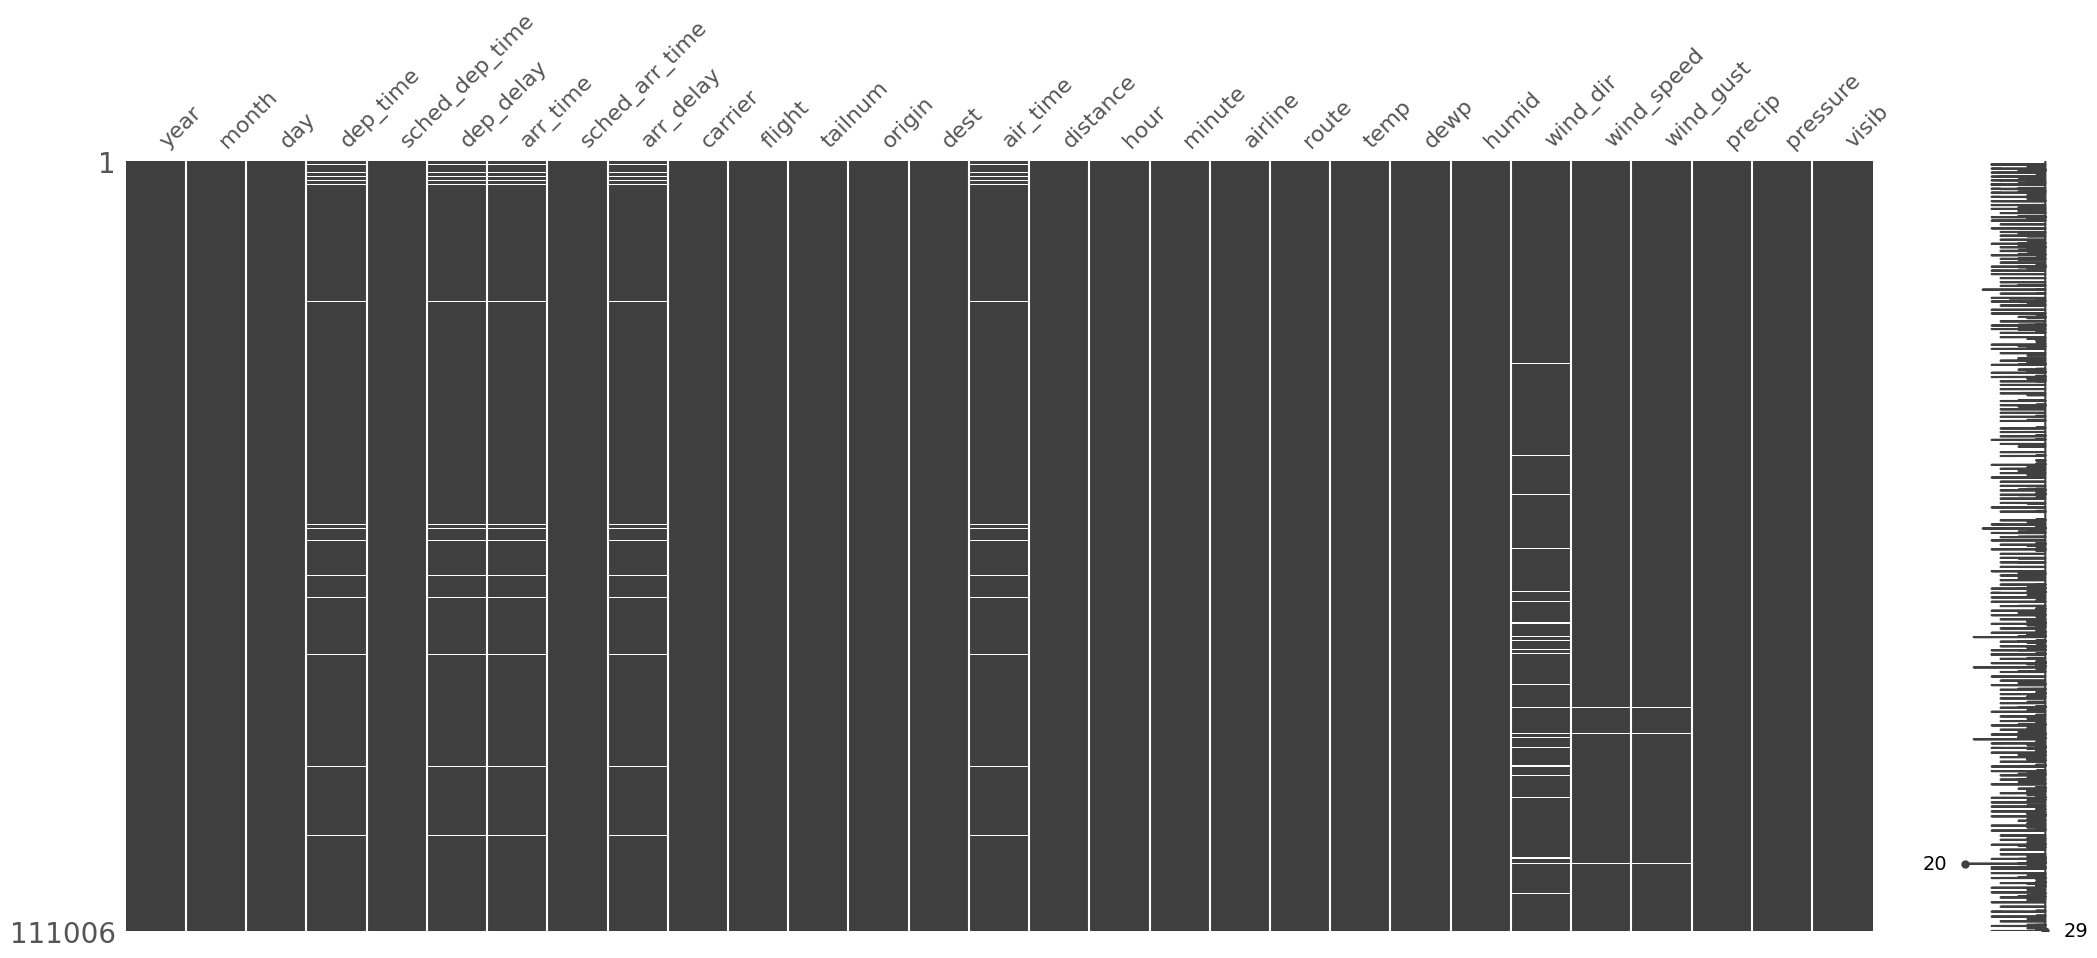

In [14]:
#Eksik verilerin görselleştirilmesi
plt.figure(figsize=(6, 4)) 
msno.matrix(df)
plt.show()

- "dep_time","dep_delay","arr_time","arr_delay","air_time" kolonlarındaki eksik verilerin aynı anda oluşmuş olabileceği grafikten görünüyor. Bu durumu sorguladığımızda bu kolonlarda 2440 değerin eksik olduğu görülmektedir.

In [15]:
df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1).sum()


2440

In [16]:
simultaneus_missing_data = df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1).sum()
ratio = simultaneus_missing_data / len(df) * 100
print(f"Aynı anda eksik olan değişkenlerin tüm veri setine oranı %{ratio:.2f}'dir.")

Aynı anda eksik olan değişkenlerin tüm veri setine oranı %2.20'dir.


In [17]:
#Eksik değer olan toplam satır sayısı veri setinin yaklaşık %5 ine karşılık gelir.
df.isnull().any(axis=1).sum()

5787

In [18]:
# Genel kabul gören kabul edilebilir eksiklik oranı olan %5' ekarşılık gelen veri sayısı 5550 dir. 
#Başka bir deyişle eksik verilerde 5550 adet eksikliğe kadar tölaransımız vardır.
threshold = len(df) * 0.05
threshold

5550.3


**Eksik verileri temizlemeden önce 6. sorunun değerlendirilmesi**

6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?

- "dep_time","dep_delay","arr_time","arr_delay","air_time" kolonlarında 2440 adet aynı anda meydana gelen eksik veriler yer almaktadır. Uçuş iptalini belirten herhangi bir kolon olmadığı için bu eksiklikleri uçuş iptali olarak kabul ettim.
Eksik olan 2440 olan değer veri setinin %2.20'si olduğundan bu sayede uçuş iptallerinin yüzdesini de elde etmiş oldum.
- İptaller en çok Alaska Airlines a aittir. Neredeyse toplam iptal edilen uçuşların %50 den fazlasını kapsamaktadır. En az iptal edilen uçuşda Hawaiian Airlines a aittir.

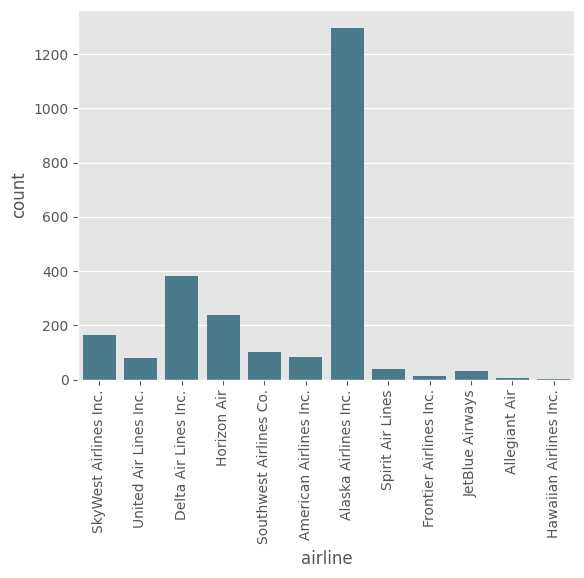

In [19]:
missing_df=df.loc[df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1),"airline"].reset_index()
sns.countplot(data=missing_df,x="airline")
plt.xticks(rotation=90)
plt.show()

**Aynı anda eksik olan %2.20 lik verinin veri setinden çıkarılması**

In [20]:
df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1).sum()

2440

In [21]:
df.dropna(subset=["dep_time", "dep_delay", "arr_time", "arr_delay", "air_time"], how="all", inplace=True)

-  Bu eksik veriler veri setinin  %2.20 sinde meydana gelmiştir. Genelde kabul gören yaklaşım eksik veriler veri setinin %5'inden fazla değilse silinmesinde sakınca olmayabilir. Ayrıca aynı anda olan eksiklik aynı anda bilgi kaybı demektir. Eksik verileri doldurma yoluna gidersek bir çok değişkeni aynı anda tahmin etmemiz gerekicek buda yanıltıcı sonuçlara yol açabilir.
-  Eksik verilerin aynı olanlarını çıkardıktan sonra arr_time değişkeninde 97 tane arr_delay değişkeninde 234 tane, airtime değişkeninde yine 234 eksik veri kalmıştır. Bu değerlerde çok küçük bir oranda kaldığından bunlarıda veri setinden çıkardım.

In [22]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time            97
sched_arr_time       0
arr_delay          234
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time           234
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3116
wind_speed         274
wind_gust          274
precip               0
pressure             0
visib                0
dtype: int64

In [23]:
df.dropna(subset=["arr_time", "arr_delay", "air_time"], inplace=True)

- tailnum eksik olan değerlerde bu işlemler sonucu silinmiştir.

In [24]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time             0
sched_arr_time       0
arr_delay            0
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time             0
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3113
wind_speed         273
wind_gust          273
precip               0
pressure             0
visib                0
dtype: int64

**Hava durumu verilerinden wind_dir, wind_speed ve wind_gust eksik verilerinin doldurulması**
- Rüzgar yönünü ifade eden wind_dir değişkeni veri setinin %2.87'sini oluşturmaktadır. Bu eksikliğin tek bir değişkende olması ve hava olayını ifade etmesinden dolayı ilave %2.87 lik veri kaybetmek istemediğimden bu değerlerin doldurulmasını daha faydalı buldum. Aynı metodu rüzgar hızını ifade eden wind_speed ve wind_gust değişkenleri içinde uygulayacağım. Doldurma işlemi için verileri tarihe göre sıralayıp ffill uygulayacağım. Bu sayede hava durumu verileri en yakın tarihteki veriler ile doldurulmuş olacaktır.


In [25]:
wind_dir=df["wind_dir"].isnull().sum()
ratio_wind = wind_dir/len(df) * 100
print(f"Eksik olan wind_dir değişkeninin tüm veri setine oranı %{ratio_wind:.2f}'dir.")

Eksik olan wind_dir değişkeninin tüm veri setine oranı %2.87'dir.


**Tarih Kolonlarının düzeltilip aynı formata getirilmesi**
- Burada amacım bozuk yapıda olan ve tarih ifade eden dep_time, sched_dep_time, arr_timeve sched_arr_time değişkenlerini yıl,ay,gün,saat ve dakika şeklinde aynı formata getirmektir.
- Ayrıca günün tarihini ifade eden yıl, ay, gün şeklinde ilave genel bir date değişken oluşturdum. 

- date değişkeninin oluşturulması

In [26]:
df["date"] = pd.to_datetime(df[["year","month","day"]])

- Oluşturduğum date değişkenini dep_time,arr_time, sched_dep_time ve sched_arr_time değişkenleri ile birleştirip bir timestamp elde etmek için string formata çevirdim

In [27]:
df["date_string"] = df["date"].astype(str).str.replace("-","")

- dep_time ve arr_time değişkenleri float sched_dep_time ve sched_arr_time integerdır. Zfill ile bu değerleri aynı formatta saat ve dakika stringine dönüştürdüm. float veri tipleri için extra integer dönüşümü uyguladım

In [28]:
# dep_time ve arr_time değişkenleri float sched_dep_time ve sched_arr_time integerdır. Zfill ile bu değerleri aynı formatta saat ve dakika stringine dönüştürdüm. float veri tipleri için extra integer dönüşümü uyguladım
df["dep_time"] = df["dep_time"].astype(int).astype(str).str.zfill(4)
df["sched_dep_time"] = df["sched_dep_time"].astype(str).str.zfill(4)
df["arr_time"] = df["arr_time"].astype(int).astype(str).str.zfill(4)
df["sched_arr_time"] = df["sched_arr_time"].astype(str).str.zfill(4)


- dep_time,arr_time, sched_dep_time ve sched_arr_time değişkenlerini date_string ile birleştirerek aynı yapıda yıl,ay,gün,hour, minute şeklinde aynı tarih yapısına getirdim ve tekrar datetime oluşturdum.
- sched_dep_time ve sched_arr_time verileri düzgün bir şekilde dönüştürüldü. Fakat dep_time ve arr_time verilerinde 0000 şeklinde olması gereken saat dakika verisi 2400 şeklinde yanlış yazılmış. 
- Bu nedenden dolayı format hatası oluştu 2400 olan verileri 0000 şekline dönüştürünce hata giderildi.
- Diğer bir çok önemli noktayı tarih verilerinden delay_time ı hesaplayıp orjinal değer ile kıyaslarken farkettim. saati 2400 dan 0000 yaptığımız zaman aynı anda günüde bir ileri atlatmamız gerekiyor.
- Bu şekilde sorunsuz bir şekilde datatime dönüşümlerini tamamladım.

In [29]:
# sched_dep_time ve sched_arr_time dönüşümü
df["sched_dep_time"] = df["date_string"].str.cat(df["sched_dep_time"])
df["sched_dep_time"] = pd.to_datetime(df["sched_dep_time"],format="%Y%m%d%H%M")

df["sched_arr_time"] = df["date_string"].str.cat(df["sched_arr_time"])
df["sched_arr_time"] = pd.to_datetime(df["sched_arr_time"],format="%Y%m%d%H%M")

# dep_time ve arr_time dönüşümü
df["dep_time"] = df["dep_time"].replace({"2400":"0000"})
df["dep_time"] = df["date_string"].str.cat(df["dep_time"])
df["dep_time"] = pd.to_datetime(df["dep_time"],format="%Y%m%d%H%M")
# datetime a dönüştürdükten sonra eğer saat 0 ise güne timedelta nesnesi ile 1 gün ilave ediyoruz.
df.loc[df["dep_time"].dt.hour == 0, "dep_time"] += pd.Timedelta(days=1)

df["arr_time"] = df["arr_time"].replace({"2400":"0000"})
df["arr_time"] = df["date_string"].str.cat(df["arr_time"])
df["arr_time"] = pd.to_datetime(df["arr_time"],format="%Y%m%d%H%M")
df.loc[df["arr_time"].dt.hour == 0, "arr_time"] += pd.Timedelta(days=1)


In [30]:
# Datetime dönüşümü uygulanan kolonların kontrolü
df.select_dtypes(include=["datetime64"]).columns

Index(['dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'date'], dtype='object')

**Eksik olan wind_dir,wind_speed, wind_gust değerlerinin ffill ile doldurulması ve temmuz ayına sarkan son 10 artık verinin kaldırılması**
- Burada verileri yıl,ay,gün, saat , dakika içeren kalkış zamanına göre sıraladım(dep_time). Bu sayede ffill uygularken en yakın değerleri dakika bazında almış oldum kalan eksik bir sonraki wind verisi ile verileri doldurdum.
- Sıralama işlemi sonrasında en alttan 10 değeri incelediğimde temmuz ayına sarktığını gördüm çünkü yukarıda 1 gün ilave etmiştik. Bu değerler sadece 10 adet olduğundan dolayı bunlarıda sildim.


In [31]:
df = df.sort_values("dep_time").reset_index(drop=True)
df.tail(12)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string
108320,2022,6,30,2022-06-30 23:53:00,2022-06-30 23:56:00,-3.0,2022-06-30 07:22:00,2022-06-30 07:31:00,-9.0,DL,841,N838DN,PDX,ATL,253.0,2172,23,56,Delta Air Lines Inc.,PDX-ATL,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630
108321,2022,6,30,2022-06-30 23:59:00,2022-06-30 23:59:00,0.0,2022-06-30 05:52:00,2022-06-30 06:08:00,-16.0,UA,603,N31412,PDX,IAH,217.0,1825,23,59,United Air Lines Inc.,PDX-IAH,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630
108322,2022,6,30,2022-07-01 00:00:00,2022-06-30 23:58:00,2.0,2022-06-30 07:47:00,2022-06-30 07:58:00,-11.0,AA,830,N916US,SEA,CLT,256.0,2279,23,58,American Airlines Inc.,SEA-CLT,75.0,47.0,36.87,10.0,10.35702,11.918651,0.0,1019.4,10.0,2022-06-30,20220630
108323,2022,6,30,2022-07-01 00:01:00,2022-06-30 21:35:00,146.0,2022-06-30 01:42:00,2022-06-30 23:20:00,142.0,WN,792,N480WN,PDX,OAK,83.0,543,21,35,Southwest Airlines Co.,PDX-OAK,76.0,54.0,46.57,270.0,8.05546,9.270062,0.0,1017.6,10.0,2022-06-30,20220630
108324,2022,6,30,2022-07-01 00:01:00,2022-06-30 23:32:00,29.0,2022-06-30 05:45:00,2022-06-30 05:21:00,24.0,AA,348,N940NN,PDX,ORD,193.0,1739,23,32,American Airlines Inc.,PDX-ORD,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630
108325,2022,6,30,2022-07-01 00:10:00,2022-06-30 00:15:00,-5.0,2022-06-30 05:14:00,2022-06-30 05:33:00,-19.0,DL,282,N341DN,PDX,MSP,161.0,1426,0,15,Delta Air Lines Inc.,PDX-MSP,74.0,55.0,51.64,320.0,10.35702,11.918651,0.0,1019.2,10.0,2022-06-30,20220630
108326,2022,6,30,2022-07-01 00:13:00,2022-06-30 00:05:00,8.0,2022-06-30 05:44:00,2022-06-30 06:02:00,-18.0,UA,501,N73259,PDX,ORD,189.0,1739,0,5,United Air Lines Inc.,PDX-ORD,74.0,55.0,51.64,320.0,10.35702,11.918651,0.0,1019.2,10.0,2022-06-30,20220630
108327,2022,6,30,2022-07-01 00:17:00,2022-06-30 23:59:00,18.0,2022-06-30 05:48:00,2022-06-30 05:57:00,-9.0,UA,782,N39461,SEA,ORD,192.0,1721,23,59,United Air Lines Inc.,SEA-ORD,75.0,47.0,36.87,10.0,10.35702,11.918651,0.0,1019.4,10.0,2022-06-30,20220630
108328,2022,6,30,2022-07-01 00:24:00,2022-06-30 00:30:00,-6.0,2022-06-30 03:03:00,2022-06-30 03:00:00,3.0,AS,88,N615AS,SEA,ANC,190.0,1448,0,30,Alaska Airlines Inc.,SEA-ANC,68.0,50.0,52.51,NaN,6.90468,7.945768,0.0,1021.9,10.0,2022-06-30,20220630
108329,2022,6,30,2022-07-01 00:25:00,2022-06-30 00:30:00,-5.0,2022-06-30 06:02:00,2022-06-30 06:27:00,-25.0,UA,505,N27213,PDX,ORD,199.0,1739,0,30,United Air Lines Inc.,PDX-ORD,74.0,55.0,51.64,320.0,10.35702,11.918651,0.0,1019.2,10.0,2022-06-30,20220630


**son 10 temmuz verisinin çıkarılması**

In [32]:
df = df.iloc[:-10]

In [33]:
df.tail(1)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string
108321,2022,6,30,2022-06-30 23:59:00,2022-06-30 23:59:00,0.0,2022-06-30 05:52:00,2022-06-30 06:08:00,-16.0,UA,603,N31412,PDX,IAH,217.0,1825,23,59,United Air Lines Inc.,PDX-IAH,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630


- ffill uygulamadan önce özet istatistikler

In [34]:
df[["wind_dir"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_dir,105212.0,164.54815,101.190198,0.0,100.0,180.0,220.0,360.0


In [35]:
df[["wind_speed"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_speed,108049.0,6.976262,4.497065,0.0,4.60312,6.90468,9.20624,27.61872


In [36]:
df[["wind_gust"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_gust,108049.0,8.028143,5.175133,0.0,5.297178,7.945768,10.594357,31.783071


In [37]:
# ffill uygulanması
wind_data_to_be_filled = ["wind_dir","wind_speed","wind_gust"]
for value in wind_data_to_be_filled:
    df[value].ffill(inplace=True)

- ffill uyguladıktan sonraki özet istatistikler
- Böylelikle özet istatistiklere bakıncada verilerin dağılımında bir bozulma olmamıştır.

In [38]:
df[["wind_dir"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_dir,108322.0,165.347575,101.61994,0.0,100.0,180.0,220.0,360.0


In [39]:
df[["wind_speed"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_speed,108322.0,6.973925,4.494517,0.0,4.60312,6.90468,9.20624,27.61872


In [40]:
df[["wind_gust"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_gust,108322.0,8.025454,5.1722,0.0,5.297178,7.945768,10.594357,31.783071


**dep_delay, arr_delay ve air_time değişkenlerinin kontrol edilmesi**
- Tarih verilerimizi uygun formata çevirdikten sonra veri setindeki dep_delay, arr_delay ve air_time değişkenlerinin doğrulamasını yaptım.

In [41]:
df.shape

(108322, 31)

- dep_delay kontrolü

In [42]:
# Yeni oluşturduğum tarih verilerinden kontrol etmek amaçlı tekrar dep_delay_check adlı sütun oluşturdum
df['dep_delay_check'] = (df['dep_time'] - df['sched_dep_time']).dt.total_seconds() / 60

In [43]:
# veri setindeki orjinal dep_delay kolonu ile karşılaştırdım.
dep_delay_check = df['dep_delay'] == df['dep_delay_check']
diff_dep_delay = len(df) - dep_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_dep_delay)

Değerleri farklı olan satır sayısı: 824


In [44]:
# örnek 2 nolu satır karşılaştırma
df.loc[[1],["dep_delay","dep_delay_check"]]

,dep_delay,dep_delay_check
1,160.0,-1280.0


Oluşan tutarsız veriler tarih verisinin yanlış girilmesinden dolayı olabilir dep_delay kolunu daha gerçekçi veri içerdiğinden doğru kabul ettim ve bu değerden farklı değerleri veri setinden çıkarmaya karar verdim.

In [45]:
df = df[dep_delay_check]
dep_delay_check = df['dep_delay'] == df['dep_delay_check']
diff_dep_delay = len(df) - dep_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_dep_delay)

Değerleri farklı olan satır sayısı: 0


- arr_delay controlü

In [46]:
# Yeni oluşturduğum tarih verilerinden kontrol etmek amaçlı tekrar arr_delay_check adlı sütun oluşturdum
df['arr_delay_check'] = (df['arr_time'] - df['sched_arr_time']).dt.total_seconds() / 60

In [47]:
# veri setindeki orjinal arr_delay kolonu ile karşılaştırdım.
arr_delay_check = df['arr_delay'] == df['arr_delay_check']
diff_arr_delay = len(df) - arr_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_arr_delay)

Değerleri farklı olan satır sayısı: 1884


Oluşan tutarsız veriler tarih verisinin yanlış girilmesinden dolayı olabilir arr_delay kolunu daha gerçekçi veri içerdiğinden doğru kabul ettim ve bu değerden farklı değerleri veri setinden çıkarmaya karar verdim.

In [48]:
df = df[arr_delay_check]
arr_delay_check = df['arr_delay'] == df['arr_delay_check']
diff_arr_delay = len(df) - arr_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_arr_delay)

Değerleri farklı olan satır sayısı: 0


**Bütün validasyon ve silme işlemleri neticesinde endüstride genellikle kabul gören %5 kabul edilebilir veri silme sınırının altında kalınmıştır. Ayrıca veri seti büyüklüğü göz önüne alındığında bu değerler kritik bir öneme sahip değildir. Temizleme işlemi sonucunda tutarlı temiz bir veriseti elde edilmiştir.**

In [49]:
row_data = 111006
deleted_data = row_data - df.shape[0]
total_cleaned_data_percentage = (deleted_data / row_data ) * 100
print(f"Toplam silinen veri %'{total_cleaned_data_percentage:.2f}'dır.")

Toplam silinen veri %'4.86'dır.


In [50]:
df.isnull().sum()

year               0
month              0
day                0
dep_time           0
sched_dep_time     0
dep_delay          0
arr_time           0
sched_arr_time     0
arr_delay          0
carrier            0
flight             0
tailnum            0
origin             0
dest               0
air_time           0
distance           0
hour               0
minute             0
airline            0
route              0
temp               0
dewp               0
humid              0
wind_dir           0
wind_speed         0
wind_gust          0
precip             0
pressure           0
visib              0
date               0
date_string        0
dep_delay_check    0
arr_delay_check    0
dtype: int64

- air_time controlü
- bu değişkende bütün değerler birbirinden farklı çıkmıştır. Air time hesaplamasında zaman farkı faktörü rol oynamış olabilir.

In [51]:
df['air_time_check'] = (df['arr_time'] - df['dep_time']).dt.total_seconds() / 60

In [52]:
air_time_check = df['air_time'] == df['air_time_check']
diff_air_time = len(df) - air_time_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_air_time)

Değerleri farklı olan satır sayısı: 105611


**Kopyaların kontrolü**
- veri setinde kopya veriye rastlanmamıştır.

In [53]:
df[df.duplicated(keep=False)]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check


In [54]:
# temizlenen ve validasyonu yapılan veri seti
df.head(3)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check
0,2022,1,1,2022-01-01 01:04:00,2022-01-01 00:43:00,21.0,2022-01-01 09:36:00,2022-01-01 09:30:00,6.0,AA,501,N413AN,SEA,MIA,312.0,2724,0,43,American Airlines Inc.,SEA-MIA,25.0,14.0,62.50,350.0,8.05546,9.270062,0.0,1020.7,10.0,2022-01-01,20220101,21.0,6.0,512.0
4,2022,1,1,2022-01-01 05:13:00,2022-01-01 05:05:00,8.0,2022-01-01 08:52:00,2022-01-01 08:46:00,6.0,UA,850,N24202,SEA,DEN,133.0,1024,5,5,United Air Lines Inc.,SEA-DEN,24.1,17.1,74.27,110.0,6.90468,7.945768,0.0,1023.0,10.0,2022-01-01,20220101,8.0,6.0,219.0
5,2022,1,1,2022-01-01 05:14:00,2022-01-01 05:15:00,-1.0,2022-01-01 08:31:00,2022-01-01 08:45:00,-14.0,WN,558,N7738A,PDX,PHX,121.0,1009,5,15,Southwest Airlines Co.,PDX-PHX,28.0,15.1,57.93,130.0,9.20624,10.594357,0.0,1023.1,10.0,2022-01-01,20220101,-1.0,-14.0,197.0


# Keşifsel Veri Analizi

**Plot Fonksiyon tanımları**
- Burada bundan sonraki kategorik ve sayısal değişkenlerde tek bir kolonu görselleştirmek için kolaylık olması ve zaman kazanmak için bir plot fonksiyonu tanımladım

In [55]:
 
def single_variable_multiple_plot(data,type="float64",numeric=True):
    """
    Veri kümesindeki tek bir değişkeni histogram, kutu grafiği ve çekirdek yoğunluk tahmini (sayısal değişkenler için) veya sayısal değişkenler için sayım grafiği ve pasta grafiği (kategorik değişkenler için) kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype == type]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category","int32"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

- diğerplot fonksiyonuda barplotun özelleştirilmiş halidir kod tekrarına düşmemek için yine bu fonksiyonu tanımladım.

In [56]:
def custom_barplot(data, categoric_value, numeric_value, agg_func):
    """
    Verilen veri setindeki kategorik bir değere göre gruplayarak, her grubun belirli bir sayısal değerinin 
    istatistiksel bir özetini çıkartır ve bu özetleri çubuk grafik olarak çizer.

    Argümanlar:
    data : pandas.DataFrame, İşlenecek veri seti.
    categoric_value : str, Veri setindeki kategorik değeri temsil eden sütunun adı.
    numeric_value : str, İstatistiksel özetinin çıkarılacağı sayısal değeri temsil eden sütunun adı.
    agg_func : str veya callable
        Grupların istatistiksel özetini hesaplamak için kullanılacak fonksiyonun adı veya kendisi.
        Örneğin: 'mean', 'median', 'sum' veya bir özel işlev (örneğin: numpy.mean gibi).

    Returns:pandas.DataFrame, Gruplanmış ve özetlenmiş veri setini içeren DataFrame.

    """
    sorted_df = data.groupby(categoric_value)[numeric_value].agg(agg_func).reset_index().sort_values(numeric_value, ascending=False)
    sns.barplot(x=categoric_value, y=numeric_value, data=data, estimator=agg_func, order=sorted_df[categoric_value], ci=False)
    plt.xticks(rotation=90)
    plt.show()
    return sorted_df

# 1.	Her havayolunun mesafeyle ilişkisini anlamak için kategorik bir değişken oluşturunuz.

- Distance değişkeninin incelenmesi

In [57]:
df["distance"].dtype

dtype('int64')

Aykırı değer olabilicek anormal bir değer gözlemlenmemiştir.

In [58]:
df[["distance"]].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,105614.0,1063.636402,746.772089,93.0,543.0,909.0,1542.0,2724.0


- Distance değişkenini incelediğimizde uçuşların genellikle 0 -1000 mil arasında yoğunlaştığını görüyoruz.

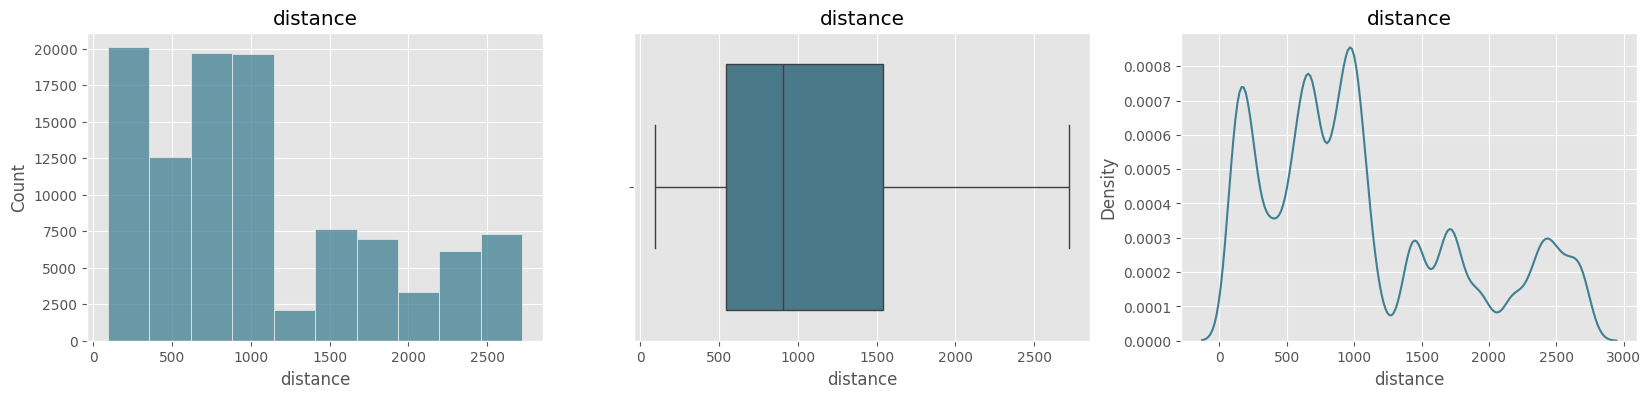

In [59]:
single_variable_multiple_plot(df[["distance"]],type="int64",numeric=True)

**Şirketlerin yaptıkları toplam uçuş mesafeleri.**
- Şirketlerin yaptıkları toplam uçuşları incelediğimizde  en fazla mesafeyi Alaska Airlines Inc. en az mesafeyi Allegiant Air firması yapmıştır. Sıralama ve grafik aşağıda gösterilmiştir.

In [60]:
df.groupby("airline")["distance"].sum().reset_index().sort_values("distance",ascending=False)

,airline,distance
0,Alaska Airlines Inc.,51901234
3,Delta Air Lines Inc.,22395311
11,United Air Lines Inc.,8248029
8,SkyWest Airlines Inc.,7107696
6,Horizon Air,6788743
2,American Airlines Inc.,5814178
9,Southwest Airlines Co.,5747645
5,Hawaiian Airlines Inc.,1884424
7,JetBlue Airways,1386325
10,Spirit Air Lines,662752


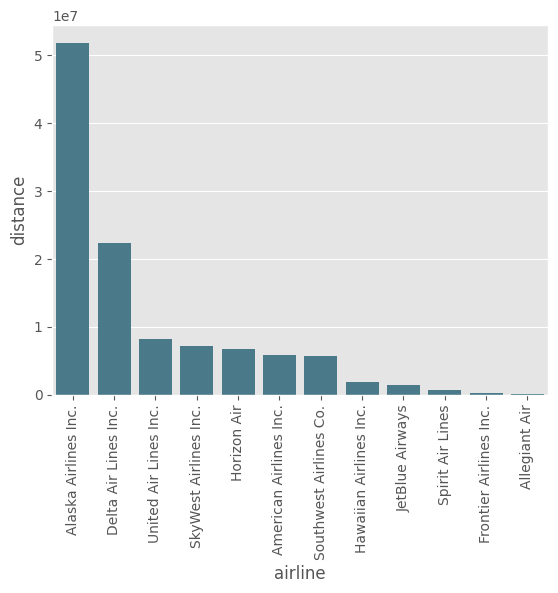

In [61]:
# Hava yoluna göre toplam mesafeler sıralı olarak görselleştirilmiştir.
sorted_airlines = custom_barplot(df,"airline","distance",sum)

**Burada kategorik değişken oluşturma amacıyla her havayolu şirketinin toplam mesafeye oranı tespit edilmiştir.**

In [62]:
total_distance = df["distance"].sum()
distance_ratio = sorted_airlines["distance"]/ total_distance
distance_ratio

0     0.462022
3     0.199362
11    0.073424
8     0.063272
6     0.060433
2     0.051758
9     0.051165
5     0.016775
7     0.012341
10    0.005900
4     0.002672
1     0.000876
Name: distance, dtype: float64

In [63]:
sorted_airlines

,airline,distance
0,Alaska Airlines Inc.,51901234
3,Delta Air Lines Inc.,22395311
11,United Air Lines Inc.,8248029
8,SkyWest Airlines Inc.,7107696
6,Horizon Air,6788743
2,American Airlines Inc.,5814178
9,Southwest Airlines Co.,5747645
5,Hawaiian Airlines Inc.,1884424
7,JetBlue Airways,1386325
10,Spirit Air Lines,662752


**daha önce grafik çizmek amacıyla oluşturulan sorted_airlines dataframeine oranlar eklenmiştir** 

In [64]:
sorted_airlines["distance_ratio_by_total"] = distance_ratio

In [65]:
sorted_airlines

,airline,distance,distance_ratio_by_total
0,Alaska Airlines Inc.,51901234,0.462022
3,Delta Air Lines Inc.,22395311,0.199362
11,United Air Lines Inc.,8248029,0.073424
8,SkyWest Airlines Inc.,7107696,0.063272
6,Horizon Air,6788743,0.060433
2,American Airlines Inc.,5814178,0.051758
9,Southwest Airlines Co.,5747645,0.051165
5,Hawaiian Airlines Inc.,1884424,0.016775
7,JetBlue Airways,1386325,0.012341
10,Spirit Air Lines,662752,0.005900


**12 adet oran kategorisi oluşmuştur**

In [66]:
sorted_airlines["distance_ratio_by_total"].nunique()

12

**merge işlemi öncesi distance kolonu silinmiştir.**

In [67]:
sorted_airlines.drop("distance",inplace=True,axis=1)
sorted_airlines

,airline,distance_ratio_by_total
0,Alaska Airlines Inc.,0.462022
3,Delta Air Lines Inc.,0.199362
11,United Air Lines Inc.,0.073424
8,SkyWest Airlines Inc.,0.063272
6,Horizon Air,0.060433
2,American Airlines Inc.,0.051758
9,Southwest Airlines Co.,0.051165
5,Hawaiian Airlines Inc.,0.016775
7,JetBlue Airways,0.012341
10,Spirit Air Lines,0.005900


**genel veri setimize merge ile havayolu şirketinin adı üzerinden birleştirilme yapılmıştır.**

In [68]:
df = df.merge(sorted_airlines, on="airline", how="left")

**Yeni kategorik oran değişkeninin atandığının doğrulaması**
- Yeni değişkenimizin atanması doğrulanmıştır

In [69]:
df["distance_ratio_by_total"].nunique()

12

In [70]:
df.loc[df["airline"]=="Alaska Airlines Inc.", "distance_ratio_by_total"].head()

8     0.462022
10    0.462022
16    0.462022
19    0.462022
22    0.462022
Name: distance_ratio_by_total, dtype: float64

In [71]:
df.loc[df["airline"]=="Allegiant Air", "distance_ratio_by_total"].head()

1208     0.000876
3109     0.000876
4647     0.000876
6822     0.000876
10486    0.000876
Name: distance_ratio_by_total, dtype: float64

**Bu kategoriyi özellikle makine öğrenmesi kısmında işe yarayacağını düşündüğüm için sayısal olarak bıraktım.**

# 2.Uçuş mesafeleri, 500 mil altındaki mesafeler, 500-1000 mil arasındaki mesafeler ve 1000 mil ve üzerindeki mesafeler olmak üzere üç ana grupta sınıflandırınız.

In [72]:
df[["distance"]].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,105614.0,1063.636402,746.772089,93.0,543.0,909.0,1542.0,2724.0


- Burada istenilen değerlere göre mesafeler gruplanmıştır.

In [73]:
bins = [0, 500, 1000, np.inf]
labels = ["0-500 miles", "500-1000 miles", "1000+ miles"]
df["distance_category"] = pd.cut(df["distance"],bins=bins, labels=labels)

In [74]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check,distance_ratio_by_total,distance_category
0,2022,1,1,2022-01-01 01:04:00,2022-01-01 00:43:00,21.0,2022-01-01 09:36:00,2022-01-01 09:30:00,6.0,AA,501,N413AN,SEA,MIA,312.0,2724,0,43,American Airlines Inc.,SEA-MIA,25.0,14.0,62.50,350.0,8.05546,9.270062,0.0,1020.7,10.0,2022-01-01,20220101,21.0,6.0,512.0,0.051758,1000+ miles
1,2022,1,1,2022-01-01 05:13:00,2022-01-01 05:05:00,8.0,2022-01-01 08:52:00,2022-01-01 08:46:00,6.0,UA,850,N24202,SEA,DEN,133.0,1024,5,5,United Air Lines Inc.,SEA-DEN,24.1,17.1,74.27,110.0,6.90468,7.945768,0.0,1023.0,10.0,2022-01-01,20220101,8.0,6.0,219.0,0.073424,1000+ miles
2,2022,1,1,2022-01-01 05:14:00,2022-01-01 05:15:00,-1.0,2022-01-01 08:31:00,2022-01-01 08:45:00,-14.0,WN,558,N7738A,PDX,PHX,121.0,1009,5,15,Southwest Airlines Co.,PDX-PHX,28.0,15.1,57.93,130.0,9.20624,10.594357,0.0,1023.1,10.0,2022-01-01,20220101,-1.0,-14.0,197.0,0.051165,1000+ miles
3,2022,1,1,2022-01-01 05:32:00,2022-01-01 05:35:00,-3.0,2022-01-01 11:09:00,2022-01-01 11:30:00,-21.0,WN,874,N8683D,PDX,MDW,205.0,1751,5,35,Southwest Airlines Co.,PDX-MDW,28.0,15.1,57.93,130.0,9.20624,10.594357,0.0,1023.1,10.0,2022-01-01,20220101,-3.0,-21.0,337.0,0.051165,1000+ miles
4,2022,1,1,2022-01-01 05:37:00,2022-01-01 05:25:00,12.0,2022-01-01 07:29:00,2022-01-01 07:30:00,-1.0,WN,349,N289CT,SEA,OAK,92.0,672,5,25,Southwest Airlines Co.,SEA-OAK,24.1,17.1,74.27,110.0,6.90468,7.945768,0.0,1023.0,10.0,2022-01-01,20220101,12.0,-1.0,112.0,0.051165,500-1000 miles


- Kategorinin dogrulaması

In [75]:
df["distance_category"].value_counts()

distance_category
1000+ miles       42737
500-1000 miles    37836
0-500 miles       25041
Name: count, dtype: int64

# 3.	Havayolu şirketleri arasında en fazla uçuşu gerçekleştiren firmaları belirleyiniz.

- En fazla toplam mesafeye sahip havayolları
- Burda Alaska airlines en fazla mesafeyi yapmıştir. En az mesafeyi Allegiant ait yapmıştır. Sıralama görselde verilmiştir.

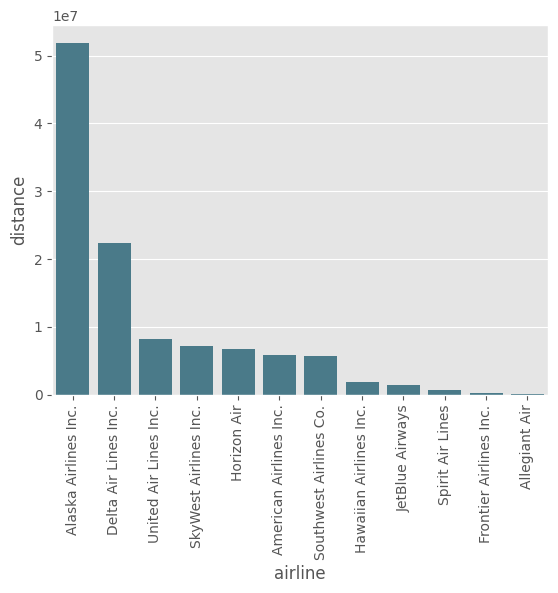

In [76]:
_ = custom_barplot(df,"airline","distance",sum)

- En fazla uçuş yapan havayolları
- Yine Alaska airlines en fazla sayıda uçuş yapmıştır. En az uçuşuda aynı şekilde Allegiant air yapmıştır. Sıralama ve uçuşların % dağılımları görselde verilmiştir.

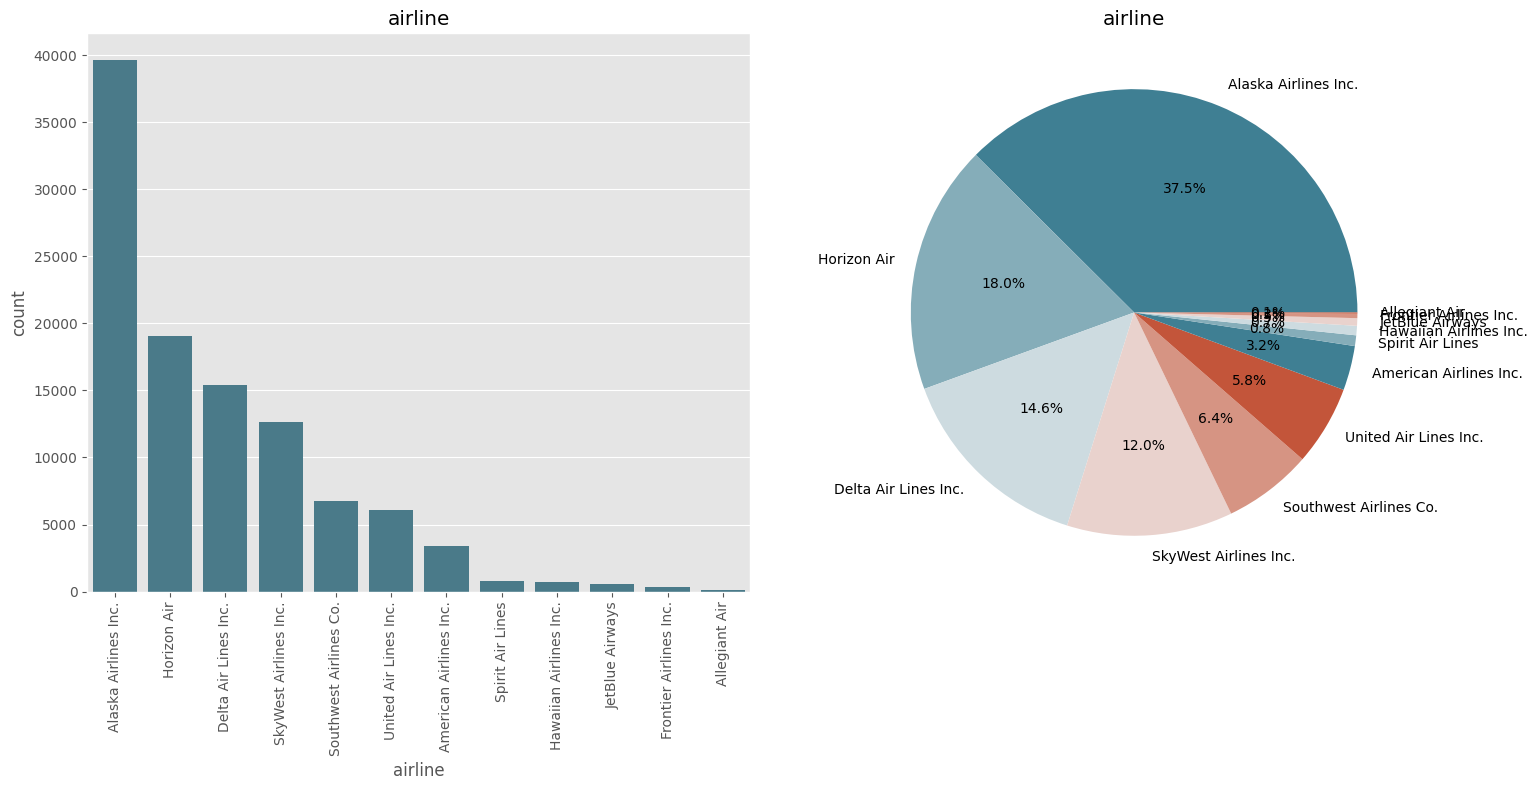

In [77]:
single_variable_multiple_plot(df[["airline"]],type="object",numeric=False)

# 4.	Gecikmeleri varsayarak havayolu şirketlerinin performansları kıyaslayınız.

**Kalkış ve varış gecikme sürelerinin dağılımları**
- Dağılımlar yüksek oranda sağa çarpıktır genelde 0 - 200 aralığındadır.Medyan değerlerine baktığımızda negatiftir.Çarpık verilerde median değerlerini daha çok dikkate aldığımızdan. Genelde gecikmeler azdır diyebiliriz.

In [78]:
df[["dep_delay","arr_delay"]].describe().T

,count,mean,std,min,25%,50%,75%,max
dep_delay,105614.0,6.833924,29.388242,-36.0,-5.0,-2.0,6.0,939.0
arr_delay,105614.0,1.176501,31.420228,-65.0,-14.0,-5.0,6.0,907.0


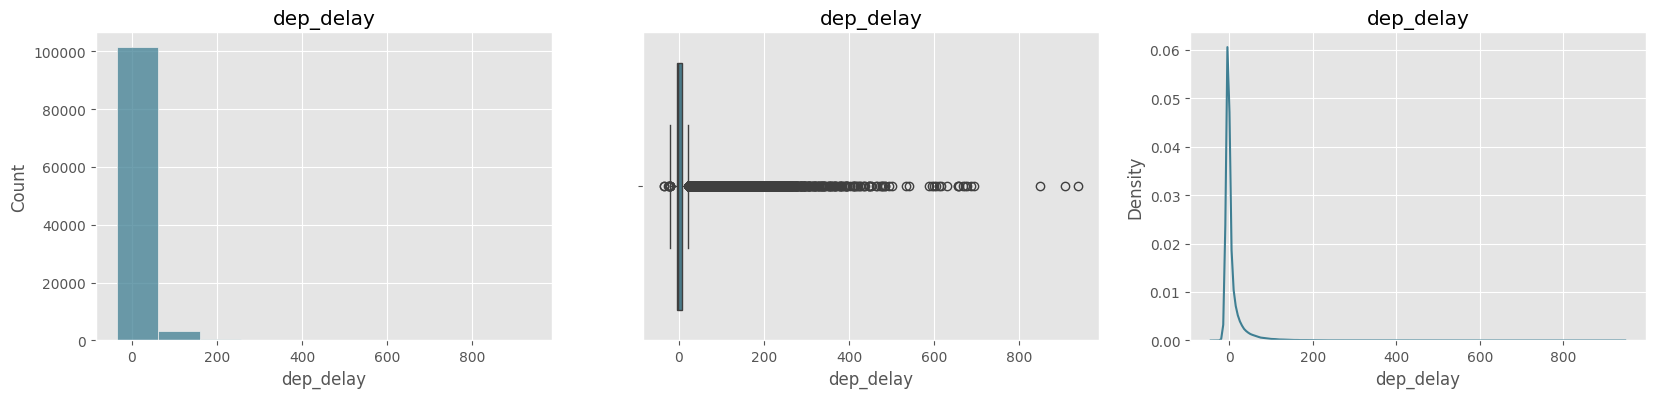

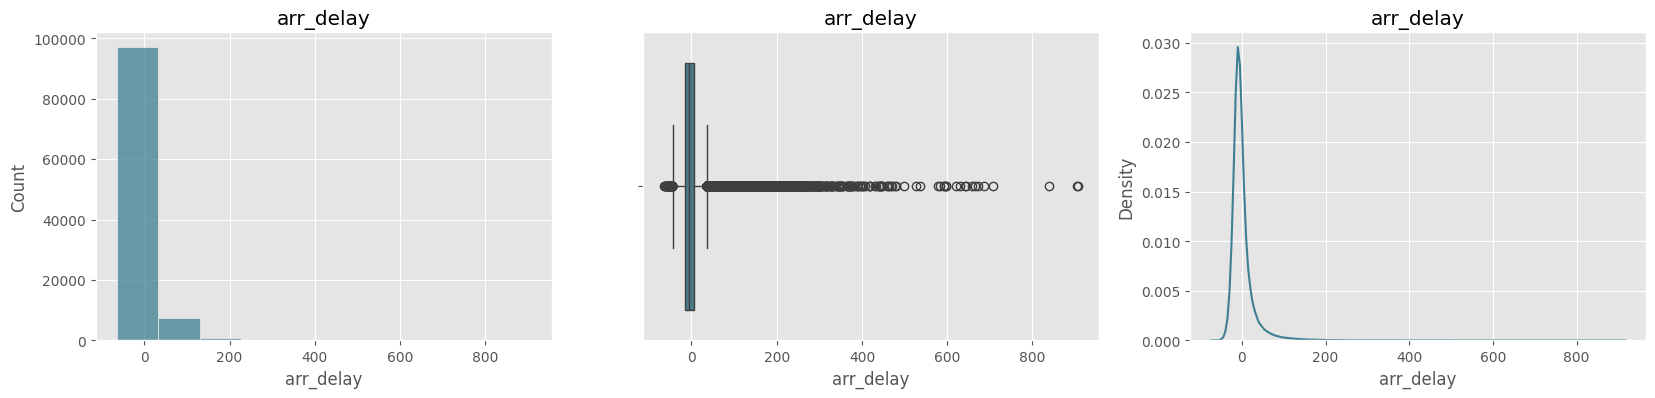

In [79]:
single_variable_multiple_plot(df[["dep_delay","arr_delay"]],numeric=True)


- Aşağıda en fazla varış gecikmesine sahip havayolları (dep_delay) grafiği gösterilmiştir. Burda da toplam değere baktığımızda varış gecikmesi en az olan Allegiant Air olarak gözükmektedir. Ama yine uçuş sayısına orantılı bir değerlendirme yapmak daha faydalı olacaktır. Alaska Airlines en fazla uçuşu yapan firmadır bu nedenle gecikmesi en fazla çıkması doğaldır.

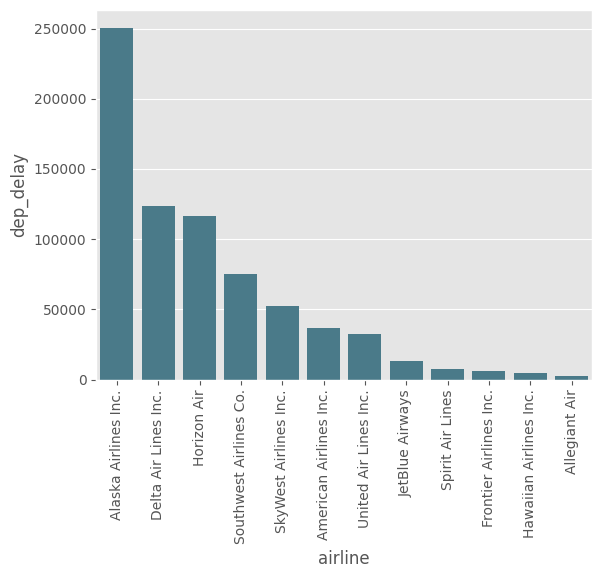

In [80]:
_ = custom_barplot(df, "airline","dep_delay",sum)

- Yine aşağıda en fazla varış gecikmesine sahip havayolları (arr_delay) grafiği gösterilmiştir. Burda da toplam değere baktığımızda varış gecikmesi en az olan United Air Lines olarak gözükmektedir. Ama yine uçuş sayısına orantılı bir değerlendirme yapmak daha faydalı olacaktır. Alaska Airlines en fazla uçuşu yapan firmadır bu nedenle gecikmesi en fazla çıkması doğaldır.

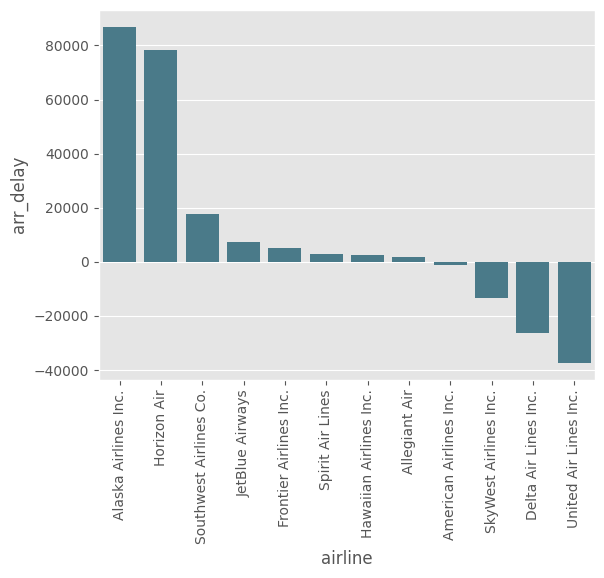

In [81]:
_ = custom_barplot(df, "airline","arr_delay",sum)

**Hava yolları şirketlerinin performans değerlendirmesi bir çok faktöre bağlıdır. Müşteri memnuniyeti anketleri, müşteri yorumları, bütçesi,  uçakların kalitesi vs. Bütün bu bilgilerin derlenip toparlanması için yeterli zaman olmadığından burada günlük kalkış ve varış gecikme değerlerinin toplamını günlük toplam uçuş sayısına bölerek bir performans metriği elde etmeye çalıştım. Yaptığım bu basit yaklaşımda bu metriğin düşük olması daha iyi performansı ifade etmektedir. Metriği oluşturmak için ilk önce her şirketin günlük uçuş sayısını elde attim**

- Havayolu şirketlerinin günlük toplam uçuş sayıları

In [82]:
df.groupby(["airline","date"]).size().reset_index().head()

,airline,date,0
0,Alaska Airlines Inc.,2022-01-01,169
1,Alaska Airlines Inc.,2022-01-02,182
2,Alaska Airlines Inc.,2022-01-03,160
3,Alaska Airlines Inc.,2022-01-04,183
4,Alaska Airlines Inc.,2022-01-05,175


- Her şirketin günlük toplam uçuş sayısının eklenmesi

In [83]:
df["daily_flight_count"] = df.groupby(["airline","date"]).transform("size")

- ekleme işleminin kontrolü

In [84]:
df.groupby(["airline","date"])["daily_flight_count"].mean().reset_index().head()

,airline,date,daily_flight_count
0,Alaska Airlines Inc.,2022-01-01,169.0
1,Alaska Airlines Inc.,2022-01-02,182.0
2,Alaska Airlines Inc.,2022-01-03,160.0
3,Alaska Airlines Inc.,2022-01-04,183.0
4,Alaska Airlines Inc.,2022-01-05,175.0


- Burada da oluşturduğum şirketlerin günlük uçuş sayıları  (daily_flight_count) grafiği gösterilmiştir. Yine Alaska airlines ilk sırada Allegiant Air son sıradadır.

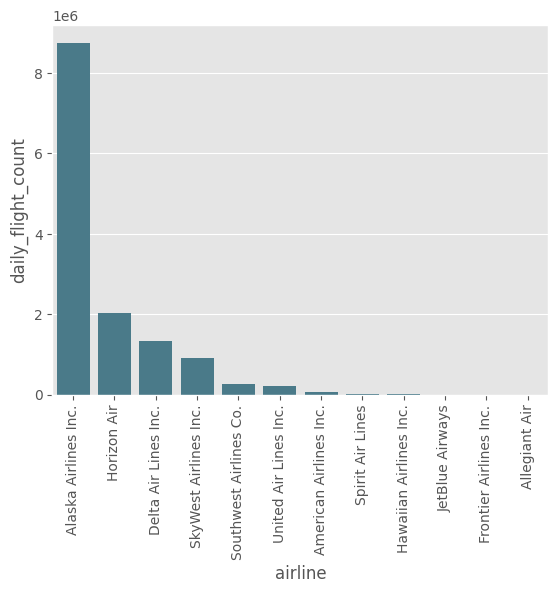

In [85]:
_ = custom_barplot(df, "airline","daily_flight_count",sum)

**Gecikmeleri varsayarak performans metriğinin oluşturulması**
- Yukarıda ayrı ayrı incelediğimiz 3 değişkeni birlikte değerlendirerek airline_daily_performance_kpi oluşturulmuştur

In [86]:
df.groupby(["airline","date"]).agg({"dep_delay":sum, "arr_delay":sum, "daily_flight_count":np.mean}).reset_index().head()

,airline,date,dep_delay,arr_delay,daily_flight_count
0,Alaska Airlines Inc.,2022-01-01,3421.0,2683.0,169.0
1,Alaska Airlines Inc.,2022-01-02,5654.0,5046.0,182.0
2,Alaska Airlines Inc.,2022-01-03,3922.0,3576.0,160.0
3,Alaska Airlines Inc.,2022-01-04,3670.0,1567.0,183.0
4,Alaska Airlines Inc.,2022-01-05,4350.0,2503.0,175.0


In [87]:
airline_delay_group = df.groupby(["airline","date"]).agg({"dep_delay":sum, "arr_delay":sum, "daily_flight_count":np.mean}).reset_index()

In [88]:
airline_delay_group["airline_daily_performance_kpi"] = (airline_delay_group["dep_delay"] + airline_delay_group["arr_delay"]) / airline_delay_group["daily_flight_count"]

In [89]:
airline_delay_group.head()

,airline,date,dep_delay,arr_delay,daily_flight_count,airline_daily_performance_kpi
0,Alaska Airlines Inc.,2022-01-01,3421.0,2683.0,169.0,36.118343
1,Alaska Airlines Inc.,2022-01-02,5654.0,5046.0,182.0,58.791209
2,Alaska Airlines Inc.,2022-01-03,3922.0,3576.0,160.0,46.862500
3,Alaska Airlines Inc.,2022-01-04,3670.0,1567.0,183.0,28.617486
4,Alaska Airlines Inc.,2022-01-05,4350.0,2503.0,175.0,39.160000


In [90]:
airline_delay_group.drop(["dep_delay","arr_delay","daily_flight_count"],axis=1,inplace=True)
airline_delay_group.head()

,airline,date,airline_daily_performance_kpi
0,Alaska Airlines Inc.,2022-01-01,36.118343
1,Alaska Airlines Inc.,2022-01-02,58.791209
2,Alaska Airlines Inc.,2022-01-03,46.862500
3,Alaska Airlines Inc.,2022-01-04,28.617486
4,Alaska Airlines Inc.,2022-01-05,39.160000


**oluşturulan metrik veri setine eklenmiştir**

In [91]:
df = df.merge(airline_delay_group, on=["airline","date"], how="left")

**yapılan işlemin doğrulaması**

In [92]:
df.groupby(["airline","date"])["airline_daily_performance_kpi"].mean().reset_index().head()

,airline,date,airline_daily_performance_kpi
0,Alaska Airlines Inc.,2022-01-01,36.118343
1,Alaska Airlines Inc.,2022-01-02,58.791209
2,Alaska Airlines Inc.,2022-01-03,46.862500
3,Alaska Airlines Inc.,2022-01-04,28.617486
4,Alaska Airlines Inc.,2022-01-05,39.160000


**Elde ettiğimiz grafiğe göre gecikmelerin az olması açısından performansı en iyiler United Airlines inc, Skywest Airlines, Delta Airlines, Alaska Airlines şeklinde küçükten büyüğe girmektedir. En kötü performans Allegiant Air'a aitttir.**

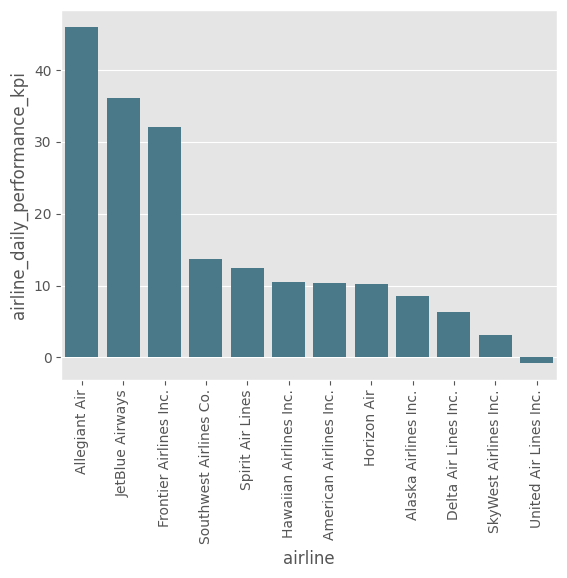

In [93]:
_ = custom_barplot(df,"airline","airline_daily_performance_kpi",np.mean)

# 5.	Havayolu performansının yılın farklı aylarına göre değişip değişmediğini ve en iyi 5 havayolu performansı ile en kötü 5 performansı gösteriniz.

**Oluşturmuş performans metriğinin aylara göre değişimi incelenmiştir**

In [94]:
df["month_check"] = df["date"].dt.month

**veri setindeki ay ile kendi oluşturduğumuz date verisindeki ay değerinin karşılaştırmasını yapıldı. Hata bulunmamaktadır.**

In [95]:
month_check = df['month'] == df['month_check']
diff_month = len(df) - month_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_month)

Değerleri farklı olan satır sayısı: 0


In [96]:
montly_total_dep_delay = df.groupby(["airline","month"])["airline_daily_performance_kpi"].sum().reset_index()

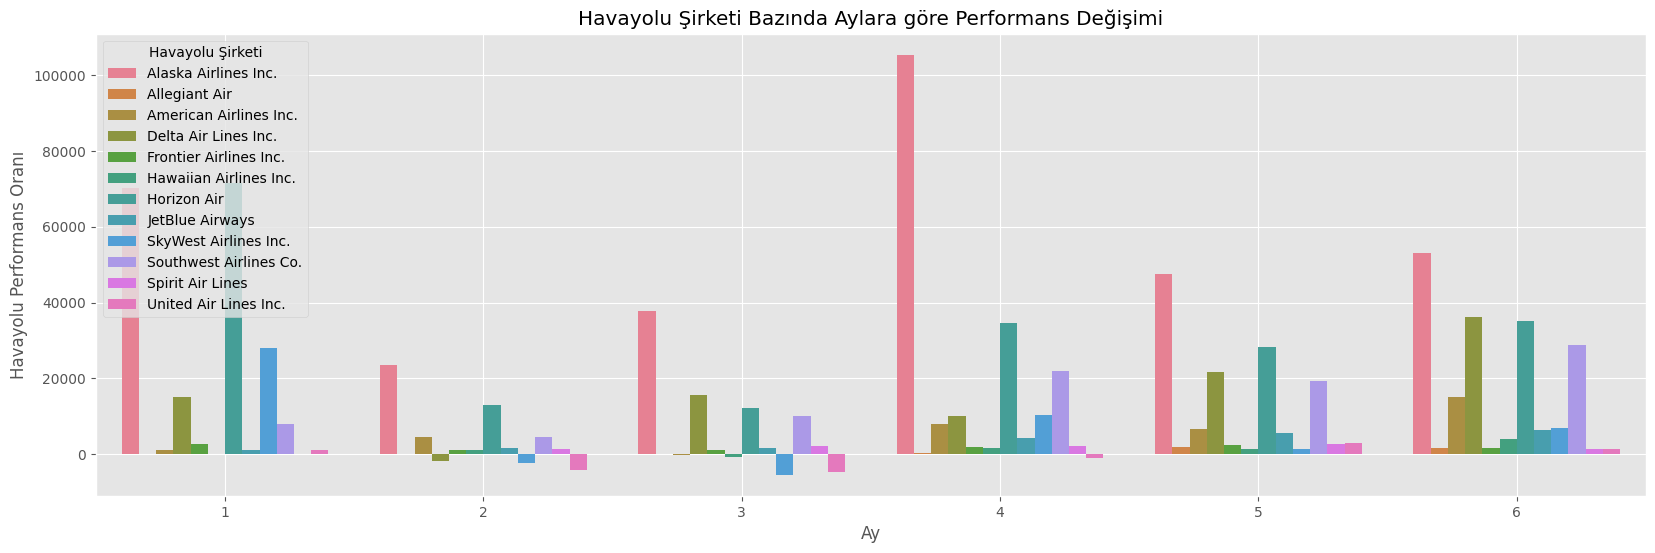

In [97]:
plt.figure(figsize=(20, 6))
sns.barplot(data=montly_total_dep_delay, x="month", y="airline_daily_performance_kpi", hue="airline")
plt.title("Havayolu Şirketi Bazında Aylara göre Performans Değişimi")
plt.xlabel("Ay")
plt.ylabel("Havayolu Performans Oranı")
plt.legend(title="Havayolu Şirketi",loc="upper left")
plt.grid(True)
plt.show()

# Sonra tekrar 5 e bak

# 6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?

**Eksik verileri temizleme kısmında cevabı verildi**

# 7.	Rotar Süresinin daha yüksek olduğu günün belirli bir saati ve/veya yılın saati var mı?

**Veri setindeki saatleri incelemesi yapıldığında hour değişkeninin sched_dep_time'dan oluşturulduğu tespit edilmiştir. Bu nedenle hour değişkeni kullanılarak analiz yapılmıştır. Ayrıca geçikmelerin en çok hangi saatte yaşandığını tespit etmek için mantıklı olan planlanan zamandaki saati baz almak olabilir**

**dep_time hour kontrolü**
- Burda ana veri setinde bulunan hour değişkenine göre meydana gelen farklılığın nedeni hour değişkeninin planlanan uçuş zamanına göre veri setine eklenmesidir(sched_dep_time).

In [98]:
df["hour_check_dep"] = df["dep_time"].dt.hour

In [99]:
hour_check_dep = df['hour'] == df['hour_check_dep']
diff_hour_dep = len(df) - hour_check_dep.sum()
print("Değerleri farklı olan satır sayısı:", diff_hour_dep)

Değerleri farklı olan satır sayısı: 23442


**sched_dep_time hour kontrolü**
- Burda veri setindeki hour değişkeninin sched_dep_time verisinden oluşturulduğunu görüyoruz. Verileri incelediğimizde 2, 3 ve 4. saatler bulunmamaktadır.
- Kalkış yeri olarak veri setinde 2 havaalanı bulunmaktadır (SEA, PDX) 2, 3 ve 4. saatlerde hiç gecikme bulunmaması bu hava alanlarında saat 2,3 ve 4 de uçuş planlaması yapılmadığını gösterebilir.

In [100]:
df[["origin"]].value_counts()

origin
SEA       78169
PDX       27445
Name: count, dtype: int64

In [101]:
df["hour_check_sched"] = df["sched_dep_time"].dt.hour

In [102]:
hour_check_sched = df['hour'] == df['hour_check_sched']
diff_hour_sched = len(df) - hour_check_sched.sum()
print("Değerleri farklı olan satır sayısı:", diff_hour_sched)

Değerleri farklı olan satır sayısı: 0


In [103]:
# saatlere göre toplam rötar sayıları
df.groupby("hour")["dep_delay"].sum().reset_index().head(6)

,hour,dep_delay
0,0,9998.0
1,1,73.0
2,5,6897.0
3,6,13403.0
4,7,34329.0
5,8,37002.0


**Saatlik uçuş sayıları**
- Saatlik gruplayıp uçuş sayılarına baktığımızda gerçektende 2, 3 ve 4 saatlerinde uçuş yapılmadığını görüyoruz.

In [104]:
hourly_flight_count = df.groupby("hour").size().reset_index()
hourly_flight_count= hourly_flight_count.rename(columns={0:"hourly_flight_count"})
hourly_flight_count.head()

,hour,hourly_flight_count
0,0,155
1,1,18
2,5,2854
3,6,5749
4,7,8827


**Saatlik uçuş sayıları grafiği**
- Bu grafiği incelediğimizde en çok uçuşların saat 07:00 ve 11:00 de yapıldığı, en az uçuşunda saat 01:00, 00:00 ve 05:00 saatlerinde yapıldığını görüyoruz.

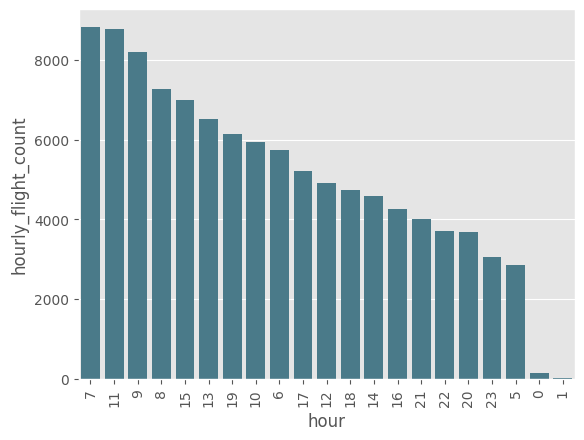

In [105]:
_ = custom_barplot(hourly_flight_count,"hour","hourly_flight_count",sum)

**Saatlik rötarlar**

In [106]:
total_hourly_delays = df.groupby("hour")["dep_delay"].sum().reset_index()
total_hourly_delays

,hour,dep_delay
0,0,9998.0
1,1,73.0
2,5,6897.0
3,6,13403.0
4,7,34329.0
5,8,37002.0
6,9,46508.0
7,10,40886.0
8,11,71373.0
9,12,37704.0


**Saatlik rötar grafiği**
- 7.sorunun cevabı olarak bu grafiği incelediğimizde yoğun uçuş saati olan 11:00 da en çok rötar olduğu görülmektedir. Ama en yoğun uçuş sayısının olduğu saat 07:00 da rötar miktarı daha azdır. Buda hava alanlarının çeşitli faktörlerden dolayı 07:00 saatinde geçikme yaşanmaması için daha çok önlem aldığını gösterebilir. Bu saate neden önem verildiği konusunda daha detay analiz yapılabilir. Gecikmelerin en az olduğu saatler yine uçuş süresininde en az olduğu 01:00, 05:00 ve 00:00  saatidir. Burda 00:00 saati için özel bir durum vardır. Uçuş sayısı çok az olmasına rağmen decikme çok fazladır. Bu durum günün saatinin tam değiştiği zamana denk gelmesinden dolayı olabilir. 

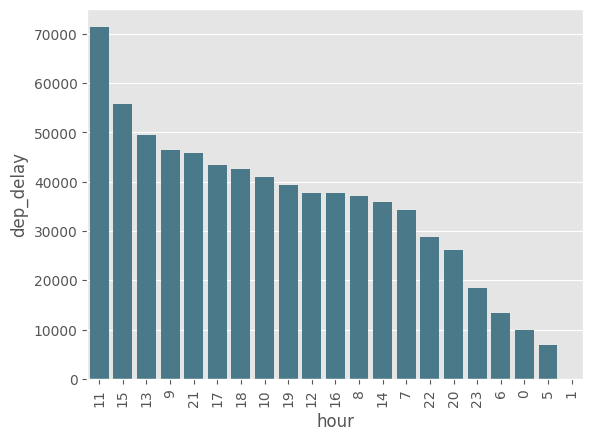

In [107]:
_ = custom_barplot(total_hourly_delays,"hour","dep_delay",sum)

---
# PROJE SORULARI
---

8.	En yüksek ROTAR(gecikme) süresine sahip güzergahlar hangileri?
9.	Makine öğrenmesi modeli kurup uçuşların gecikme sürelerini tahmin ediniz.
10.	Modeli Değerlendiriniz.

# 8.	En yüksek ROTAR(gecikme) süresine sahip güzergahlar hangileri?

**Veri setrinde 149 adet güzergah vardır**

In [108]:
df[["route"]].value_counts().shape

(149,)

**En yüksek rötar süresine sahip ilk 5 güzergah SEA-ANC, SEA-PDX, SEA-LAS, SEA-DEN ve SEA-LAX 'dir.**

In [109]:
df.groupby("route")["dep_delay"].sum().reset_index().sort_values("dep_delay",ascending=False).head()

,route,dep_delay
58,SEA-ANC,28868.0
121,SEA-PDX,27451.0
102,SEA-LAS,24760.0
76,SEA-DEN,22537.0
103,SEA-LAX,21488.0


**En az rötar süresi olan 5 güzergahda PDX-SNA, PDX-TPA, PDX-BZN, PDX-SBP ve PDX-LIH'dır.**

In [110]:
df.groupby("route")["dep_delay"].sum().reset_index().sort_values("dep_delay",ascending=False).tail()

,route,dep_delay
51,PDX-SNA,35.0
54,PDX-TPA,18.0
7,PDX-BZN,-10.0
45,PDX-SBP,-80.0
28,PDX-LIH,-310.0


In [111]:
routes = df.groupby("route")["dep_delay"].sum().reset_index().head(10)

**En yüksek rötar süresine sahip ilk 10 güzergahın sıralı görseleştirilmesi**

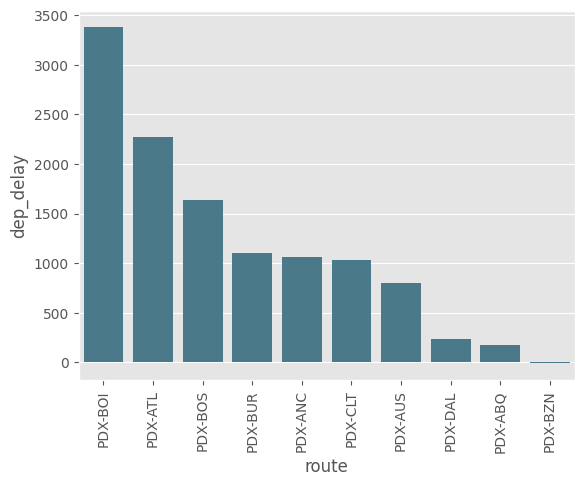

In [112]:
_ = custom_barplot(routes,"route","dep_delay",sum)

# İlave İşlemler

**Uçak sayısı eklenmesi**

- Kuyruk numarası değişkeni saydırılığ firma başı uçak sayısı hesaplanmıştır.
- En fazla uçağa sahip havayou firması Southwest Airlines Co. en az uçağa sahip havayolu firması Allegiant Air'dir. Sıralamalı liste ver görsel aşağıda sunulmuştur. 
- Uçak sayılarınıda veri setine kategorik değişken olarak eklenmiştir.

In [113]:
df.groupby("airline")["tailnum"].nunique().reset_index().sort_values("tailnum",ascending=False)

,airline,tailnum
9,Southwest Airlines Co.,728
2,American Airlines Inc.,612
3,Delta Air Lines Inc.,610
11,United Air Lines Inc.,525
8,SkyWest Airlines Inc.,272
0,Alaska Airlines Inc.,228
7,JetBlue Airways,157
10,Spirit Air Lines,120
4,Frontier Airlines Inc.,108
6,Horizon Air,61


In [117]:
airline_total_aircraft_count = df.groupby("airline")["tailnum"].nunique().reset_index()
airline_total_aircraft_count

,airline,tailnum
0,Alaska Airlines Inc.,228
1,Allegiant Air,30
2,American Airlines Inc.,612
3,Delta Air Lines Inc.,610
4,Frontier Airlines Inc.,108
5,Hawaiian Airlines Inc.,42
6,Horizon Air,61
7,JetBlue Airways,157
8,SkyWest Airlines Inc.,272
9,Southwest Airlines Co.,728


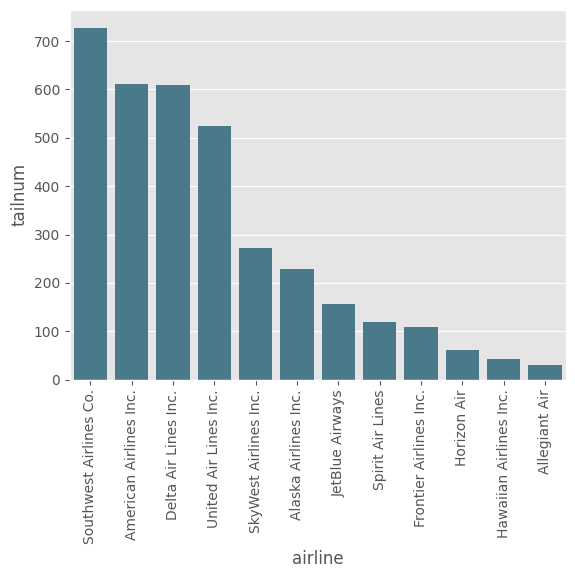

In [118]:
_ = custom_barplot(airline_total_aircraft_count,"airline","tailnum",sum)

In [119]:
airline_total_aircraft_count = df.groupby("airline")["tailnum"].nunique()
df["aircraft_count_by_airline"] = df["airline"].map(airline_total_aircraft_count)

In [120]:
df.head(1)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check,distance_ratio_by_total,distance_category,daily_flight_count,airline_daily_performance_kpi,month_check,hour_check_dep,hour_check_sched,aircraft_count_by_airline
0,2022,1,1,2022-01-01 01:04:00,2022-01-01 00:43:00,21.0,2022-01-01 09:36:00,2022-01-01 09:30:00,6.0,AA,501,N413AN,SEA,MIA,312.0,2724,0,43,American Airlines Inc.,SEA-MIA,25.0,14.0,62.5,350.0,8.05546,9.270062,0.0,1020.7,10.0,2022-01-01,20220101,21.0,6.0,512.0,0.051758,1000+ miles,19,17.631579,1,1,0,612


In [122]:
df.groupby("airline")["aircraft_count_by_airline"].mean().reset_index()

,airline,aircraft_count_by_airline
0,Alaska Airlines Inc.,228.0
1,Allegiant Air,30.0
2,American Airlines Inc.,612.0
3,Delta Air Lines Inc.,610.0
4,Frontier Airlines Inc.,108.0
5,Hawaiian Airlines Inc.,42.0
6,Horizon Air,61.0
7,JetBlue Airways,157.0
8,SkyWest Airlines Inc.,272.0
9,Southwest Airlines Co.,728.0


# 9.	Makine öğrenmesi modeli kurup uçuşların gecikme sürelerini tahmin ediniz.

**Korelasyon Analizi**
- Hedef değişkenimiz dep_delay dir. Bu değişken ile diğer sayısal değişkenlerin arasında bir korelasyon olup olmadığı analiz edilmiştir. Analizden önce kontrol yada hesaplama amacıyla oluşturulmuş sütünlar kaldırılmıştır.




In [123]:

columns_to_be_remove = ["date_string","dep_delay_check","arr_delay_check","air_time_check","month_check","hour_check_dep","hour_check_sched"]
df.drop(columns_to_be_remove, axis=1, inplace=True)
df.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'airline', 'route', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed',
       'wind_gust', 'precip', 'pressure', 'visib', 'date',
       'distance_ratio_by_total', 'distance_category', 'daily_flight_count',
       'airline_daily_performance_kpi', 'aircraft_count_by_airline'],
      dtype='object')



**Heatmap incelemesi ve birbiri arasında korelasyonlu değişkenlerin tespiti**

- Burada görselin daha anlaşılır olması için np.triu ile ones_like birlikte kullanılarak bool değerler oluşurup üst üçgenin gösterilmemesini sağlanmıştır.
Aşağıda heatmapi incelediğimizde korelasyonlar renkler ile açıkça görülmektedir.

Değişkenler arasında %70 den fazla korelasyonu olanlar multicollinearity problemi oluşmaması için korelasyonlu olanları biri kullanılmayacaktır.
Yüksek korelasyonlu değişkenler aynı bilgiyi ifade ettiklerinden aralarındaki küçük farklar makine öğrenimi modelini yanıltabilir.

Bu değişkenler:
- arr_delay - dep delay: dep delay zaten target değişken olduğundan arr_delay tek başına kullanılabilir.
- distance - air_time: 0.99 luk çok yüksek korelasyon vardır. air_time modelde kullanılmayacaktır.
- flight - distance_ratio_by_total: 0.70 lik negatif yönde yüksek korelasyon vardır. flight değişkeni zaten kardinalitesi yüksek bir sayısal değişken olduğu için kullanılmayacaktır.
- temp - dewp: dewp çiğ noktasını temp sıcaklığı ifade eder. 0.75 korelasyon olduğundan dewp kullanılmayacaktır.
- wind_speed - wind_gust: aralarında 1 yani tam pozitif korelasyon vardır. Aynı şeyi ifade ettiklerinden wind_gust kullanılmayacaktır.
- distance_ratio_by_total - daily_flight_count: yine 0.92 lik çok yüksek korelasyon olduğundan daily_flight_count kullanılmayacaktır.

Diğer negatif ve pozitif korelasyonlar tablodan görülmektedir.

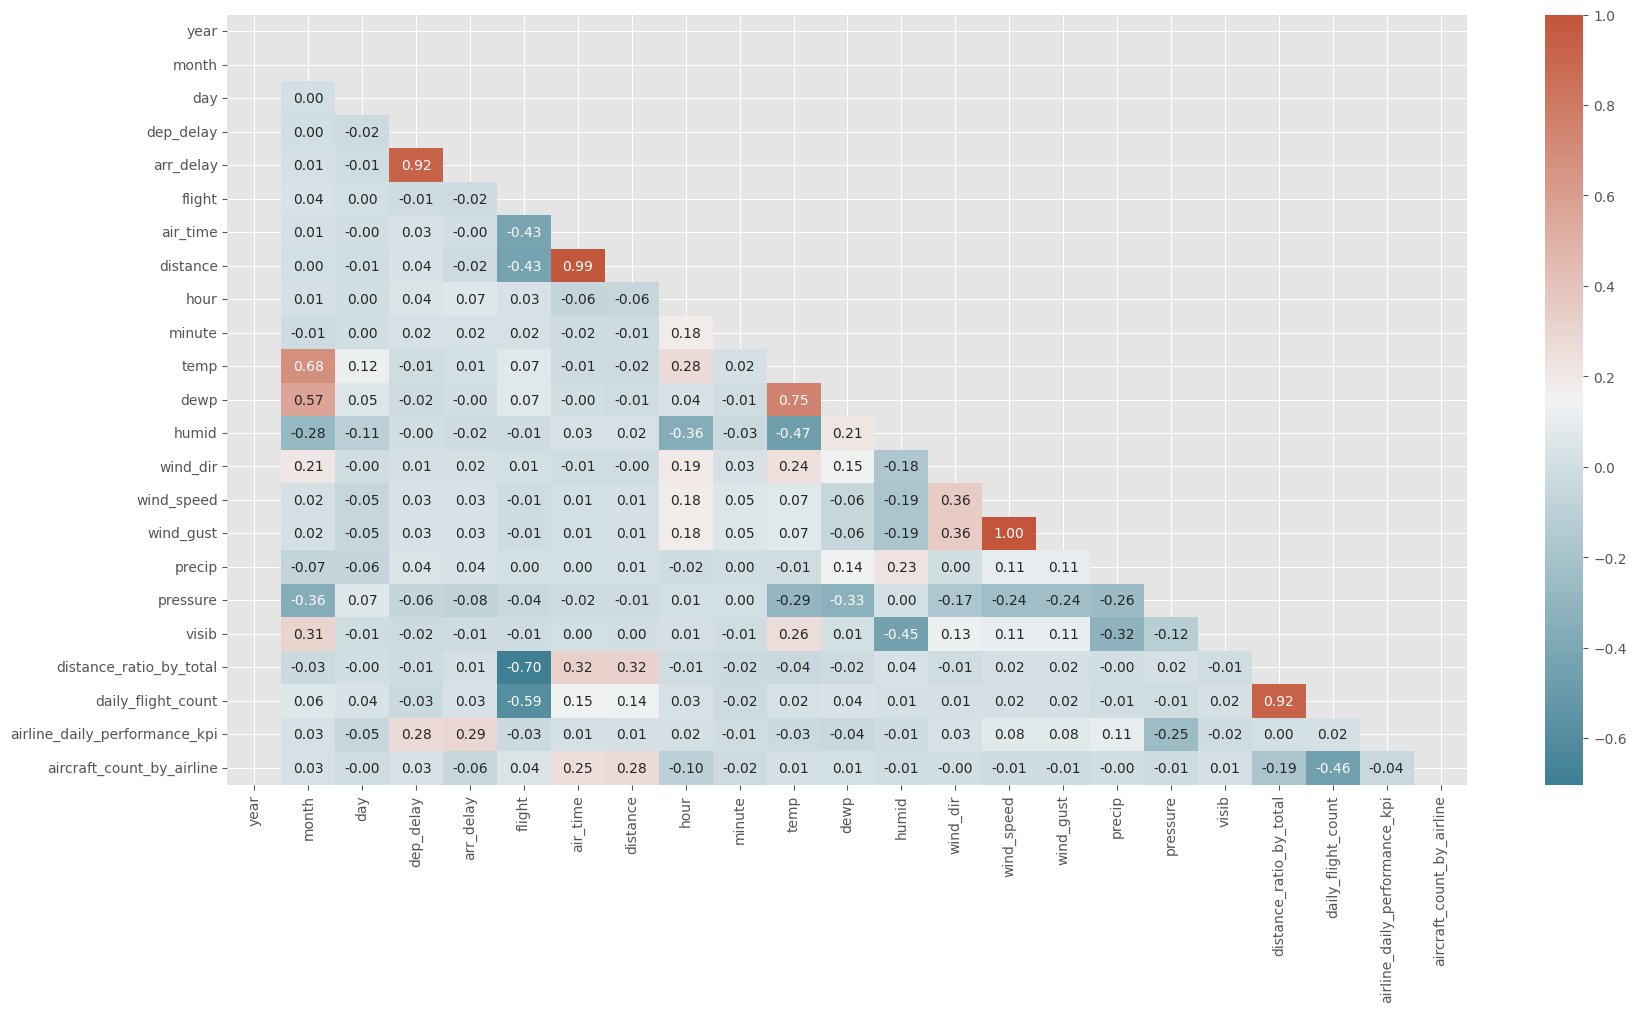

In [125]:
plt.figure(figsize=(20, 10))
num_variables = df.select_dtypes(include=["float64","int64"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Target değişken (dep_delay) diğer değişkenlerin korelasyonlarının tespiti**
- Burada target değişken dep_delay ile sayısal değişkenlerin korelasyonuna bakılmıştır. Eşik değer %30 korelasyonlu olarak belirlenmiş ve görselleştirilmiştir. 
- Birbiri ile korelasyonlu değişkenlerde kaldırılıp tam olarak hedef değişken ile korelasyonlu değişkenlerin kaç adet olduğu tespit edilmiştir. 
- Target değişken ile bağımsız değişkenler arasında %30 korelasyondan yüksek 8 değişken tespit edilmiştir.

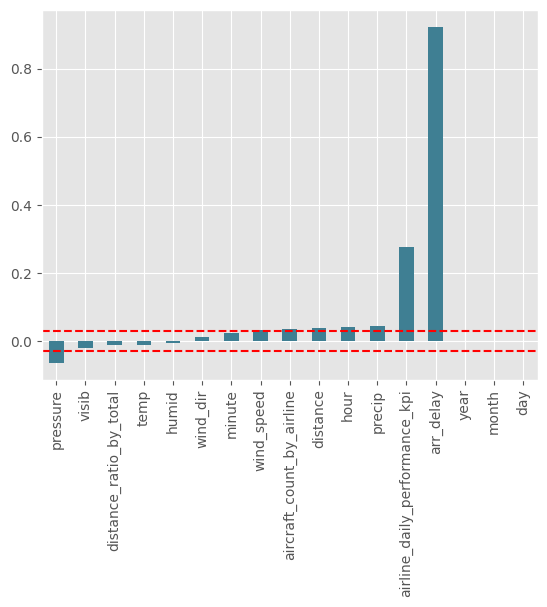

In [137]:
corrs_that_will_not_be_used = ["air_time","flight","dewp","wind_gust","daily_flight_count","dep_delay"]
tri_df["dep_delay"].drop(corrs_that_will_not_be_used).sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

- Burada %30 dan büyük değerleri almak için sorgulama yapıldı. Bu nedenle abs ile negatif değerler pozitife çevrilöiştir. Target değişkenin kaç değişken ile %30 üzeri korelasyonu olduğu belirlenmiştir.

In [140]:
corrs_that_will_be_drop = ["air_time","flight","dewp","wind_gust","daily_flight_count"]
cor_target = abs(tri_df["dep_delay"])
cor_target.drop(corrs_that_will_be_drop,inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(df.select_dtypes(include=["float64","int64"]).columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 23
Korelasyonlu özellik sayısı: 8


**Modelleme öncesinde değişkenlere yapılacak işlemler**
1. Kullanılmayacak değişkenler belirlenmiştir.
2. Label encoding yapılacak ordinal kategorik değişkenler belirlenmiştir.
3. One hot encoding yapılacak nominal kategorik değişkenler belirlenmiştir.

**1. Kullanılmayacak değişkenlerin belirlenmesi**
- Korelasyon analizinden elde ettiğimiz değişkenler kullanılmayacaktır.
- Kardinalitesi yüksek kategorik değişkenler kullanılmayacaktır. Çok boyutluluk laneti kavramından uzaklaşmak amaçlanmıştır. Yüksek boyutlu veri overfittinge daha yatkın olmaktadir.
- Kardinalitesi yüksek sayısal değişkenler kullanılmayacaktır.
- Datetime verileri kullanılmayacaktır.
- diğer aynı şeyi ifade eden değişkenler.

- korelasyon analizinden elde edilen kullanılmayacak değişkenler.

In [161]:

corrs = ["air_time","flight","dewp","wind_gust","daily_flight_count"]

- kardinalitesi yüksek categorik kolonlarda 80 üzeri kattegori vardır.

In [156]:
cat_but_car = [col for col in df.columns if df[col].nunique() > 80 and str(df[col].dtypes) in ["category", "object"]]
cat_but_car

['tailnum', 'dest', 'route']

- flight korelasyon analizinde kullanılmayacak olarak tespit edilmiştir. Aynı zamanda kardinalitesi çok yüksek kategorik değişkendir.

In [153]:

df["flight"].nunique()

1099

- date değişkenleri

In [162]:
date_features = df.select_dtypes(include="datetime64").columns.to_list()
date_features

['dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'date']

- Diğer değişkenler
- origin: 2 adet hava alanını ifade eder gerekli görülmedi.
- carrier: airline ın kısaltmasıdır

In [159]:
other_features = ["carrier","origin"]

**Toplam kullanılmayacak kolonlar**

In [163]:
cols_will_be_not_used = corrs + cat_but_car + date_features + other_features
cols_will_be_not_used

['air_time',
 'flight',
 'dewp',
 'wind_gust',
 'daily_flight_count',
 'tailnum',
 'dest',
 'route',
 'dep_time',
 'sched_dep_time',
 'arr_time',
 'sched_arr_time',
 'date',
 'carrier',
 'origin']

In [168]:
feature_columns = [col for col in df.columns if col not in cols_will_be_not_used]
df = df[feature_columns]
df.head()

,year,month,day,dep_delay,arr_delay,distance,hour,minute,airline,temp,humid,wind_dir,wind_speed,precip,pressure,visib,distance_ratio_by_total,distance_category,airline_daily_performance_kpi,aircraft_count_by_airline
0,2022,1,1,21.0,6.0,2724,0,43,American Airlines Inc.,25.0,62.50,350.0,8.05546,0.0,1020.7,10.0,0.051758,1000+ miles,17.631579,612
1,2022,1,1,8.0,6.0,1024,5,5,United Air Lines Inc.,24.1,74.27,110.0,6.90468,0.0,1023.0,10.0,0.073424,1000+ miles,25.884615,525
2,2022,1,1,-1.0,-14.0,1009,5,15,Southwest Airlines Co.,28.0,57.93,130.0,9.20624,0.0,1023.1,10.0,0.051165,1000+ miles,43.459459,728
3,2022,1,1,-3.0,-21.0,1751,5,35,Southwest Airlines Co.,28.0,57.93,130.0,9.20624,0.0,1023.1,10.0,0.051165,1000+ miles,43.459459,728
4,2022,1,1,12.0,-1.0,672,5,25,Southwest Airlines Co.,24.1,74.27,110.0,6.90468,0.0,1023.0,10.0,0.051165,500-1000 miles,43.459459,728


**2. Label Encoding**
- distance_category büyüklük ifade eden ordinal kategorik değişken olduğu için label encoding yapıldı. İlk önce sıralı kategorik olarak veri tipi değiştirildi.

In [170]:
df["distance_category"].value_counts()

distance_category
1000+ miles       42737
500-1000 miles    37836
0-500 miles       25041
Name: count, dtype: int64

In [ ]:
df.head(10)

In [ ]:
categories = ["0-500 miles","500-1000 miles","1000+ miles"]
df["distance_category"] = df["distance_category"].astype("category")
df["distance_category"] = df["distance_category"].cat.set_categories(categories,ordered=True)
df["distance_category"].dtype

In [ ]:
le = LabelEncoder()
df["distance_category"] = le.fit_transform(df["distance_category"]) 